<a href="https://colab.research.google.com/github/summermccune/Tokenization-Testing-for-Malware-Data/blob/main/Tokenization_Malware.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

### Imports

In [1]:
!pip install hmmlearn
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installe

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/NSF REU/malware")
!ls

Mounted at /content/drive
4fams  7fams.csv  7fams_test.csv  7fams_train.csv  Embeddings  Families  Plots	Tokenizers  Tokens


In [70]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from collections import Counter
from datasets import load_dataset
from tokenizers.pre_tokenizers import Whitespace
from tokenizers import Tokenizer, ByteLevelBPETokenizer, SentencePieceBPETokenizer
from tokenizers.models import BPE, WordPiece, Unigram
from tokenizers.trainers import BpeTrainer, WordPieceTrainer, UnigramTrainer
from transformers import PreTrainedTokenizerFast
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from hmmlearn import hmm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score, f1_score, precision_score, recall_score

###Functions

In [4]:
def saveToCsv(pathName, labels, data):
  '''
  Saves the data with its labels into a pkl file
  pathName = what pkl file will be named & where it's placed
  '''
  df = pd.DataFrame(list(zip(labels, data)), columns=['Label', 'Opcodes'])
  df.to_csv(pathName+'.csv')
  return df

In [5]:
def saveToPkl(pathName, labels, data):
  '''
  Saves the data with its labels into a pkl file
  pathName = what pkl file will be named & where it's placed
  '''
  df = pd.DataFrame(list(zip(labels, data)), columns=['Label', 'Opcodes'])
  df.to_pickle(pathName+'.pkl')
  return df

In [6]:
def readCsvSplit(csvFile):
  '''
  Reads in the given csv file as dataframe
  Splits the opcodes & labels of dataframe into series
  '''
  df = pd.read_csv(csvFile+'.csv')
  x = df['Opcodes']
  y = df['Label']
  return x, y

In [7]:
def readPklSplit(pklFile):
  '''
  Reads in the given csv file as dataframe
  Splits the opcodes & labels of dataframe into series
  '''
  df = pd.read_pickle(pklFile+'.pkl')
  x = df['Opcodes']
  y = df['Label']
  return x, y

### Shortcut to read in 7 families saved csv file ###

In [ ]:
all_data = pd.read_csv("7fams.csv")

### Split training/testing data + saving to csv files ###

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(all_data['Opcodes'], all_data['Label'], test_size=0.3, random_state=7, stratify=all_data['Label'])
print(y_test.value_counts())
print(y_train.value_counts())
print(x_train.head())
print(y_train.head())
print(x_test.head())
print(y_test.head())

saveToCsv('7fams_train', y_train, x_train)
saveToCsv('7fams_test', y_test, x_test)

Label
FakeRean       300
Renos          300
Winwebsec      300
Vobfus         300
BHO            300
CeeInject      300
OnLineGames    300
Name: count, dtype: int64
Label
Vobfus         700
BHO            700
Renos          700
CeeInject      700
FakeRean       700
OnLineGames    700
Winwebsec      700
Name: count, dtype: int64
5942    ljmp jae xchg push jae or out push jae add lea...
658     push mov cmpl jne mov leave ret cmpl jne cmpl ...
441     add inc add pop inc outsl outsl insb gs outsb ...
4817    push mov sub mov mov xor cmp ja mov addl orl x...
4997    push mov mov sub mov mov mov mov mov mov mov m...
Name: Opcodes, dtype: object
5942    Vobfus
658        BHO
441        BHO
4817     Renos
4997     Renos
Name: Label, dtype: object
2953    and push mov call add test js mov test mov mov...
2505    sbb add mov xchg mov scas call sub cmp pushw b...
4921    sahf addl add addl add addl add addb adc add a...
6302    add add fs or cltd push or add add add add add...
5564    ljmp jae 

###Shortcut to read in train/test split csv file

In [ ]:
x_train, y_train = readCsvSplit('7fams_train')
x_test, y_test = readCsvSplit('7fams_test')

### Split/Read in SMALL dataset

In [ ]:
# SPLITTING: FOR THE SAKE OF TESTING OUT CODE: USING ONLY 400/4000 OF DATASET
x_train, x_rest, y_train, y_rest = train_test_split(x_train, y_train, test_size=0.9, random_state=7, stratify=y_train)
x_test, x_rest, y_test, y_rest = train_test_split(x_test, y_test, test_size=0.9, random_state=7, stratify=y_test)

saveToCsv('4fams_small_train', y_train, x_train)
saveToCsv('4fams_small_test', y_test, x_test)

Label                                            Opcodes
0        Vobfus  mov cmp xchg cmp or jae mov cmp add jae jb jae...
1        Vobfus  rcrb add add ja jb lret mov jb lret mov jb lre...
2      FakeRean  or ret int3 int3 int3 int3 int3 mov push mov m...
3        Vobfus  jg mov jb add mov jb xchg mov jb int3 mov jb a...
4     Winwebsec  push mov mov pop ret and sub lret cs hlt in sc...
..          ...                                                ...
75    Winwebsec  push mov sub push mov movl movl movl movl movl...
76       Vobfus  std mov mov jb cmp add jb mov mov jb loopne jb...
77    Winwebsec  shll iret int test sbb insl push pop nop mov l...
78  OnLineGames  mov inc and and add in sub movsl in fnstsw inc...
79     FakeRean  add add add call mov call ret int3 int3 int3 i...

[80 rows x 2 columns]

###Read in SMALL dataset

In [116]:
# FOR THE SAKE OF TESTING CODE: USE ONLY 400/4000 SAMPLES
x_train, y_train = readCsvSplit('4fams/4fams_small_train')
x_test, y_test = readCsvSplit('4fams/4fams_small_test')
print(y_train.value_counts())
print(y_test.value_counts())

Label
OnLineGames    80
Winwebsec      80
Vobfus         80
FakeRean       80
Name: count, dtype: int64
Label
Vobfus         20
FakeRean       20
Winwebsec      20
OnLineGames    20
Name: count, dtype: int64


## Tokenization Methods

####Single Words: Most common; M=31 (white space separation) ####

#####Defined Functions for topX & removeNonVocab

In [ ]:
# Single Words: Most common; M=31 (white space separation)
def topX(max, series):
  '''
  Finds the top X (max) most commonly occuring tokens in given series
  '''
  ctr = Counter()
  for row in series:
    ctr.update(row.split())
  top_words = [count[0] for count in ctr.most_common(max)]
  return top_words

def removeNonVocab(vocab, series):
  '''
  Removes the words not in the given vocab list from the series
  '''
  rows = []
  vocab_str = '|'.join(vocab)
  pattern = '\\b((?!\\b( |' + vocab_str + ')\\b).)*\\b'
  for row in series:
    row = re.sub(pattern, '', row)
    rows.append(row.split())
  return rows # list of token lists

def removeNonVocabBERT(vocab, series):
  '''
  Removes the words not in the given vocab list from the series
  '''
  rows = []
  vocab_str = '|'.join(vocab)
  pattern = '\\b((?!\\b( |' + vocab_str + ')\\b).)*\\b'
  for row in series:
    row = re.sub(pattern, '', row)
    rows.append(row)
  return rows # list of token lists

#####Generate Vocab Dictionary

In [ ]:
# generate top 31 tokens vocab
T31_vocab = topX(31, x_train)
print(T31_vocab)

['add', 'mov', 'push', 'pop', 'inc', 'call', 'xchg', 'dec', 'or', 'cmp', 'xor', 'lea', 'sub', 'and', 'adc', 'sbb', 'test', 'in', 'out', 'movl', 'jmp', 'int3', 'nop', 'ret', 'imul', 'je', 'lods', 'scas', 'stos', 'lret', 'jne']


In [ ]:
# shortcut to read in T31 vocab
T31_vocab = ['add', 'mov', 'push', 'pop', 'inc', 'call', 'xchg', 'dec', 'or', 'cmp', 'xor', 'lea', 'sub', 'and', 'adc', 'sbb', 'test', 'in', 'out', 'movl', 'jmp', 'int3', 'nop', 'ret', 'imul', 'je', 'lods', 'scas', 'stos', 'lret', 'jne']

#####Batch Remove NonVocab from Train

In [ ]:
size = len(x_train)//4
p1 = removeNonVocab(T31_vocab, x_train[:size])

In [ ]:
p2 = removeNonVocab(T31_vocab, x_train[size: size*2])

In [ ]:
p3 = removeNonVocab(T31_vocab, x_train[size*2:size*3])

In [ ]:
p4 = removeNonVocab(T31_vocab, x_train[size*3: size*4])

In [ ]:
# join batched remove lists back together
remain_top31_train = [*p1, *p2, *p3, *p4]
top31_train = saveToPkl('Tokens/T31_train', y_train, remain_top31_train)
print(top31_train.shape)
top31_train.head()

######For BERT?

In [ ]:
# Gotta tokenize differently (i.e. save as str not list) for BERT embeddings
size = len(x_train)//4
p1 = removeNonVocab(T31_vocab, x_train[:size])
p2 = removeNonVocab(T31_vocab, x_train[size: size*2])
p3 = removeNonVocab(T31_vocab, x_train[size*2:size*3])
p4 = removeNonVocab(T31_vocab, x_train[size*3: size*4])

# join batched remove lists back together
remain_top31_train = [*p1, *p2, *p3, *p4]
top31_train = saveToCsv('Tokens/T31_train', y_train, remain_top31_train)
print(top31_train.shape)
top31_train.head()

#####Batch Remove NonVocab from Test

In [ ]:
size = len(x_test)//2
p1 = removeNonVocab(T31_vocab, x_test[:size])

In [ ]:
p2 = removeNonVocab(T31_vocab, x_test[size: size*2])

In [ ]:
# join batched remove lists back together
remain_top31_test = [*p1, *p2]
top31_test = saveToPkl('Tokens/T31_test', y_test, remain_top31_test)
print(top31_test.shape)
top31_test.head()

(80, 2)


Label                                            Opcodes
0     Vobfus  [mov, cmp, xchg, cmp, or, mov, cmp, add, push,...
1     Vobfus  [add, add, lret, mov, lret, mov, lret, mov, or...
2   FakeRean  [or, ret, int3, int3, int3, int3, int3, mov, p...
3     Vobfus  [mov, add, mov, xchg, mov, int3, mov, add, mov...
4  Winwebsec  [push, mov, mov, pop, ret, and, sub, lret, in,...

#### Methods for BPE, WPC, UNI, BBPE, SPC

In [ ]:
# General tokenizer & trainer setup
batch_size = 1000
files = {"train": "4fams/4fams_small_train.csv", "test": "4fams/4fams_small_test.csv"}
dataset = load_dataset("csv", data_files=files)
unk_token = "<UNK>"
spl_tokens = ["<UNK>", "<SEP>", "<MASK>", "<CLS>"]
v_size = 100 # Hyperparameter tuning

def batch_iterator(data):
  # Data refers to either "train" or "test"
  for i in range(0, len(dataset), batch_size):
      yield dataset[data]['Opcodes'][i : i + batch_size]

def prepare_tokenizer_trainer(alg):
    """
    Prepares the tokenizer and trainer with unknown & special tokens
    """
    if alg == 'BPE':
        tokenizer = Tokenizer(BPE(unk_token = unk_token))
        trainer = BpeTrainer(special_tokens = spl_tokens, vocab_size=v_size)
    elif alg == 'UNI':
        tokenizer = Tokenizer(Unigram())
        trainer = UnigramTrainer(unk_token= unk_token, special_tokens = spl_tokens, vocab_size=v_size)
    elif alg == 'WPC':
        tokenizer = Tokenizer(WordPiece(unk_token = unk_token))
        trainer = WordPieceTrainer(special_tokens = spl_tokens, vocab_size=v_size)

    tokenizer.pre_tokenizer = Whitespace()
    return tokenizer, trainer

def train_tokenizer(alg):
    """
    Trains the tokenizer
    """
    if (alg == 'BPE' or alg == 'UNI' or alg == 'WPC'):
      tokenizer, trainer = prepare_tokenizer_trainer(alg)
      tokenizer.train_from_iterator(batch_iterator('train'), trainer=trainer)
      return tokenizer
    elif alg == 'BBPE':
      tokenizer = ByteLevelBPETokenizer()
      tokenizer.train_from_iterator(batch_iterator('train'),vocab_size=v_size)
    elif alg == 'SPC':
      tokenizer = SentencePieceBPETokenizer()
      tokenizer.train_from_iterator(batch_iterator('train'),vocab_size=v_size)
    tokenizer.save("Tokenizers/"+alg+"-trained.json")
    return tokenizer

def encode(tokenizer, toStr):
  train_encode = tokenizer.encode_batch(dataset['train']['Opcodes'])
  if toStr: train_tokens = [" ".join(encoding.tokens) for encoding in train_encode]
  else: train_tokens = [encoding.tokens for encoding in train_encode]

  test_encode = tokenizer.encode_batch(dataset['test']['Opcodes'])
  if toStr: test_tokens = [" ".join(encoding.tokens) for encoding in test_encode]
  else: test_tokens = [encoding.tokens for encoding in test_encode]
  return train_tokens, test_tokens

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

#### BPE: Character Byte Pair Encoding

In [ ]:
# Train Character BPE tokenizer
BPE_tokenizer = train_tokenizer('BPE')
BPE_tokenizer.save("Tokenizers/BPE-trained.json")

In [ ]:
# Or load in previously trained tokenizer
BPE_tokenizer = Tokenizer.from_file("Tokenizers/BPE-trained.json")

In [ ]:
BPE_train_tokens, BPE_test_tokens = encode(BPE_tokenizer, False)
print(BPE_train_tokens[0])
print(BPE_test_tokens[0])

['mov', 'inc', 'and', 'and', 'add', 'in', 'sub', 'mov', 'sl', 'in', 'f', 'n', 'st', 's', 'w', 'inc', 'l', 'push', 'push', 'push', 'pop', 'xor', 'lea', 'lo', 'c', 'k', 'st', 'o', 's', 'st', 'o', 's', 'st', 'o', 's', 'adc', 'int', 'st', 'o', 's', 'add', 'and', 'and', 'jmp', 'and', 'test', 'call', 'jb', 'e', 'mov', 'inc', 'add', 'b', 'r', 'or', 'b', 'd', 'a', 's', 'pop', 'st', 'i', 'mov', 'push', 'mov', 'lea', 'push', 'and', 'sbb', 'xor', 'push', 'pop', 'out', 'f', 'u', 'c', 'o', 'm', 'f', 'b', 'st', 'p', 'j', 'e', 'mov', 'push', 'call', 'push', 'in', 'mov', 'mov', 'pop', 'in', 'inc', 'xchg', 'inc', 'inc', 'dec', 'push', 'ret', 'd', 'a', 's', 'dec', 'push', 'sub', 'd', 'i', 'v', 'l', 'push', 'adc', 'push', 'add', 'adc', 'cmp', 'jn', 'e', 'pop', 'test', 'sbb', 'loop', 'e', 'mov', 'cl', 'c', 'pop', 'pop', 'pop', 'push', 'pop', 'pop', 'pop', 'lea', 'v', 'e', 'ret', 'xor', 'push', 'cmp', 'mov', 'f', 'i', 'st', 'l', 'pop', 'cl', 'd', 'add', 'or', 'add', 'f', 's', 'l', 'ret', 'in', 'l', 'jmp', 

In [ ]:
# Save tokenized data
BPE_train = saveToPkl('Tokens/BPE_train', dataset['train']['Label'], BPE_train_tokens)
BPE_test = saveToPkl('Tokens/BPE_test', dataset['test']['Label'], BPE_test_tokens)
print(BPE_train.head())
print(BPE_test.head())

         Label                                            Opcodes
0  OnLineGames  [mov, inc, and, and, add, in, sub, mov, sl, in...
1    Winwebsec  [and, l, add, pop, a, push, add, pop, a, push,...
2    Winwebsec  [or, nop, add, dec, dec, or, adc, l, inc, sub,...
3    Winwebsec  [push, a, xor, add, push, call, add, l, dec, d...
4       Vobfus  [j, g, mov, jb, add, mov, jb, xchg, mov, jb, p...
       Label                                            Opcodes
0     Vobfus  [mov, cmp, xchg, cmp, or, j, a, e, mov, cmp, a...
1     Vobfus  [r, c, r, b, add, add, j, a, jb, l, ret, mov, ...
2   FakeRean  [or, ret, int3, int3, int3, int3, int3, mov, p...
3     Vobfus  [j, g, mov, jb, add, mov, jb, xchg, mov, jb, i...
4  Winwebsec  [push, mov, mov, pop, ret, and, sub, l, ret, c...


In [ ]:
# trying out saving as whitespace separated string for BERT!
BPE_train_tokens, BPE_test_tokens = encode(BPE_tokenizer, True)
print(BPE_train_tokens[0])
print(BPE_test_tokens[0])

mov inc and and add in sub mov sl in f n st s w inc l push push push pop xor lea lo c k st o s st o s st o s adc int st o s add and and jmp and test call jb e mov inc add b r or b d a s pop st i mov push mov lea push and sbb xor push pop out f u c o m f b st p j e mov push call push in mov mov pop in inc xchg inc inc dec push ret d a s dec push sub d i v l push adc push add adc cmp jn e pop test sbb loop e mov cl c pop pop pop push pop pop pop lea v e ret xor push cmp mov f i st l pop cl d add or add f s l ret in l jmp jn e j a e s ca s pop out sb sbb c s adc in sb mov call add re p z r c r b mov l call ret inc add xchg l ret in g s j e dec e n te r xchg f l d t pop int3 inc add out sb int o a r p l s ca s f l d c w i ret out sl cmp r c ll jb imul out xchg j a e mov ret pop mov j s xor l ret mov sb mov sb mov sl cmp sb cmp sl dec xor test st o s st o s lo ds lo ds xor xor s ca s mov mov xor mov mov mov pop out sb f w a i t in sl mov j p mov or or in sb jmp lea push add f d i v r pop a 

In [ ]:
# Save tokenized data
BPE_train = saveToCsv('Tokens/BPE_train', dataset['train']['Label'], BPE_train_tokens)
BPE_test = saveToCsv('Tokens/BPE_test', dataset['test']['Label'], BPE_test_tokens)
print(BPE_train.head())
print(BPE_test.head())

         Label                                            Opcodes
0  OnLineGames  mov inc and and add in sub mov sl in f n st s ...
1    Winwebsec  and l add pop a push add pop a push add pop a ...
2    Winwebsec  or nop add dec dec or adc l inc sub push adc a...
3    Winwebsec  push a xor add push call add l dec dec j l cmp...
4       Vobfus  j g mov jb add mov jb xchg mov jb push jb int3...
       Label                                            Opcodes
0     Vobfus  mov cmp xchg cmp or j a e mov cmp add j a e jb...
1     Vobfus  r c r b add add j a jb l ret mov jb l ret mov ...
2   FakeRean  or ret int3 int3 int3 int3 int3 mov push mov m...
3     Vobfus  j g mov jb add mov jb xchg mov jb int3 mov jb ...
4  Winwebsec  push mov mov pop ret and sub l ret c s h l t i...


#### WPC: WordPiece ####

In [ ]:
# WordPiece
WPC_tokenizer = train_tokenizer('WPC')
WPC_tokenizer.save("Tokenizers/WPC-trained.json")

In [ ]:
# Or load in previously trained tokenizer
WPC_tokenizer = Tokenizer.from_file("Tokenizers/WPC-trained.json")

In [ ]:
WPC_train_tokens, WPC_test_tokens = encode(WPC_tokenizer)
print(WPC_train_tokens[0])
print(WPC_test_tokens[0])

['mov', 'inc', 'a', '##n', '##d', 'a', '##n', '##d', 'add', 'in', 's', '##u', '##b', 'mov', '##s', '##l', 'in', 'f', '##n', '##s', '##t', '##s', '##w', 'inc', '##l', 'push', 'push', 'push', 'pop', 'x', '##o', '##r', 'le', '##a', 'l', '##o', '##c', '##k', 's', '##t', '##o', '##s', 's', '##t', '##o', '##s', 's', '##t', '##o', '##s', 'ad', '##c', 'in', '##t', 's', '##t', '##o', '##s', 'add', 'a', '##n', '##d', 'a', '##n', '##d', 'j', '##mp', 'a', '##n', '##d', 't', '##e', '##s', '##t', 'call', 'j', '##b', '##e', 'mov', 'inc', 'add', '##b', 'r', '##o', '##r', '##b', 'd', '##a', '##s', 'pop', 's', '##t', '##i', 'mov', 'push', 'mov', 'le', '##a', 'push', 'a', '##n', '##d', 's', '##b', '##b', 'x', '##o', '##r', 'push', 'pop', 'o', '##u', '##t', 'f', '##u', '##c', '##o', '##m', 'f', '##b', '##s', '##t', '##p', 'j', '##e', 'mov', 'push', 'call', 'push', 'in', 'mov', 'mov', 'pop', 'in', 'inc', 'x', '##c', '##h', '##g', 'inc', 'inc', 'dec', 'push', 'r', '##e', '##t', 'd', '##a', '##s', 'dec', 'pu

In [ ]:
# Save tokenized data
WPC_train = saveToPkl('Tokens/WPC_train', dataset['train']['Label'], WPC_train_tokens)
WPC_test = saveToPkl('Tokens/WPC_test', dataset['test']['Label'], WPC_test_tokens)
print(WPC_train.head())
print(WPC_test.head())

         Label                                            Opcodes
0  OnLineGames  [mov, inc, a, ##n, ##d, a, ##n, ##d, add, in, ...
1    Winwebsec  [a, ##n, ##d, ##l, add, pop, ##a, push, add, p...
2    Winwebsec  [o, ##r, n, ##op, add, dec, dec, o, ##r, ad, #...
3    Winwebsec  [push, ##a, x, ##o, ##r, add, push, call, add,...
4       Vobfus  [j, ##g, mov, j, ##b, add, mov, j, ##b, x, ##c...
       Label                                            Opcodes
0     Vobfus  [mov, cmp, x, ##c, ##h, ##g, cmp, o, ##r, j, #...
1     Vobfus  [r, ##c, ##r, ##b, add, add, j, ##a, j, ##b, l...
2   FakeRean  [o, ##r, r, ##e, ##t, in, ##t, ##3, in, ##t, #...
3     Vobfus  [j, ##g, mov, j, ##b, add, mov, j, ##b, x, ##c...
4  Winwebsec  [push, mov, mov, pop, r, ##e, ##t, a, ##n, ##d...


#### SPC: SentencePiece ####

In [ ]:
# SentencePiece
SPC_tokenizer = train_tokenizer('SPC')
SPC_tokenizer.save("Tokenizers/SPC-trained.json")

In [ ]:
# Or load in previously trained tokenizer
SPC_tokenizer = Tokenizer.from_file("Tokenizers/SPC-trained.json")

In [ ]:
SPC_train_tokens, SPC_test_tokens = encode(SPC_tokenizer)
print(SPC_train_tokens[0])
print(SPC_test_tokens[0])

['▁mov', '▁inc', '▁and', '▁and', '▁add', '▁in', '▁sub', '▁mov', 's', 'l', '▁in', '▁f', 'n', 'st', 's', 'w', '▁inc', 'l', '▁push', '▁push', '▁push', '▁pop', '▁xor', '▁lea', '▁lo', 'c', 'k', '▁st', 'o', 's', '▁st', 'o', 's', '▁st', 'o', 's', '▁adc', '▁int', '▁st', 'o', 's', '▁add', '▁and', '▁and', '▁j', 'mp', '▁and', '▁test', '▁call', '▁j', 'b', 'e', '▁mov', '▁inc', '▁add', 'b', '▁r', 'or', 'b', '▁d', 'a', 's', '▁pop', '▁st', 'i', '▁mov', '▁push', '▁mov', '▁lea', '▁push', '▁and', '▁sbb', '▁xor', '▁push', '▁pop', '▁out', '▁f', 'u', 'c', 'o', 'm', '▁f', 'b', 'st', 'p', '▁j', 'e', '▁mov', '▁push', '▁call', '▁push', '▁in', '▁mov', '▁mov', '▁pop', '▁in', '▁inc', '▁xchg', '▁inc', '▁inc', '▁dec', '▁push', '▁r', 'et', '▁d', 'a', 's', '▁dec', '▁push', '▁sub', '▁d', 'i', 'v', 'l', '▁push', '▁adc', '▁push', '▁add', '▁adc', '▁cmp', '▁jn', 'e', '▁pop', '▁test', '▁sbb', '▁lo', 'op', 'e', '▁mov', '▁c', 'l', 'c', '▁pop', '▁pop', '▁pop', '▁push', '▁pop', '▁pop', '▁pop', '▁lea', 'v', 'e', '▁r', 'et', '▁xo

In [ ]:
# Save tokenized data
SPC_train = saveToPkl('Tokens/SPC_train', dataset['train']['Label'], SPC_train_tokens)
SPC_test = saveToPkl('Tokens/SPC_test', dataset['test']['Label'], SPC_test_tokens)
print(SPC_train.head())
print(SPC_test.head())

         Label                                            Opcodes
0  OnLineGames  [▁mov, ▁inc, ▁and, ▁and, ▁add, ▁in, ▁sub, ▁mov...
1    Winwebsec  [▁and, l, ▁add, ▁pop, a, ▁push, ▁add, ▁pop, a,...
2    Winwebsec  [▁or, ▁, n, op, ▁add, ▁dec, ▁dec, ▁or, ▁adc, l...
3    Winwebsec  [▁push, a, ▁xor, ▁add, ▁push, ▁call, ▁add, l, ...
4       Vobfus  [▁j, g, ▁mov, ▁j, b, ▁add, ▁mov, ▁j, b, ▁xchg,...
       Label                                            Opcodes
0     Vobfus  [▁mov, ▁cmp, ▁xchg, ▁cmp, ▁or, ▁j, a, e, ▁mov,...
1     Vobfus  [▁r, c, r, b, ▁add, ▁add, ▁j, a, ▁j, b, ▁l, r,...
2   FakeRean  [▁or, ▁r, et, ▁int, 3, ▁int, 3, ▁int, 3, ▁int,...
3     Vobfus  [▁j, g, ▁mov, ▁j, b, ▁add, ▁mov, ▁j, b, ▁xchg,...
4  Winwebsec  [▁push, ▁mov, ▁mov, ▁pop, ▁r, et, ▁and, ▁sub, ...


#### UNI: Unigram Subword ####

In [ ]:
# Unigram (subword)
UNI_tokenizer = train_tokenizer('UNI')
UNI_tokenizer.save("Tokenizers/UNI-trained.json")

In [ ]:
# Or load in previously trained tokenizer
UNI_tokenizer = Tokenizer.from_file("Tokenizers/UNI-trained.json")

In [ ]:
UNI_train_tokens, UNI_test_tokens = encode(UNI_tokenizer)
print(UNI_train_tokens[0])
print(UNI_test_tokens[0])

['mov', 'inc', 'and', 'and', 'add', 'i', 'n', 'sub', 'movsl', 'i', 'n', 'fnst', 's', 'w', 'inc', 'l', 'push', 'push', 'push', 'pop', 'xor', 'lea', 'l', 'o', 'ck', 's', 't', 'o', 's', 's', 't', 'o', 's', 's', 't', 'o', 's', 'a', 'd', 'c', 'int', 's', 't', 'o', 's', 'add', 'and', 'and', 'jmp', 'and', 'test', 'call', 'j', 'b', 'e', 'mov', 'inc', 'add', 'b', 'r', 'o', 'r', 'b', 'd', 'a', 's', 'pop', 's', 't', 'i', 'mov', 'push', 'mov', 'lea', 'push', 'and', 'sbb', 'xor', 'push', 'pop', 'out', 'f', 'u', 'c', 'o', 'm', 'f', 'b', 's', 't', 'p', 'j', 'e', 'mov', 'push', 'call', 'push', 'i', 'n', 'mov', 'mov', 'pop', 'i', 'n', 'inc', 'xchg', 'inc', 'inc', 'd', 'e', 'c', 'push', 'ret', 'd', 'a', 's', 'd', 'e', 'c', 'push', 'sub', 'd', 'i', 'v', 'l', 'push', 'a', 'd', 'c', 'push', 'add', 'a', 'd', 'c', 'cmp', 'j', 'n', 'e', 'pop', 'test', 'sbb', 'loope', 'mov', 'c', 'l', 'c', 'pop', 'pop', 'pop', 'push', 'pop', 'pop', 'pop', 'leave', 'ret', 'xor', 'push', 'cmp', 'mov', 'fist', 'l', 'pop', 'c', 'l

In [ ]:
# Save tokenized data
UNI_train = saveToPkl('Tokens/UNI_train', dataset['train']['Label'], UNI_train_tokens)
UNI_test = saveToPkl('Tokens/UNI_test', dataset['test']['Label'], UNI_test_tokens)
print(UNI_train.head())
print(UNI_test.head())

         Label                                            Opcodes
0  OnLineGames  [mov, inc, and, and, add, i, n, sub, movsl, i,...
1    Winwebsec  [and, l, add, pop, a, push, add, pop, a, push,...
2    Winwebsec  [o, r, n, o, p, add, d, e, c, d, e, c, o, r, a...
3    Winwebsec  [push, a, xor, add, push, call, add, l, d, e, ...
4       Vobfus  [j, g, mov, j, b, add, mov, j, b, xchg, mov, j...
       Label                                            Opcodes
0     Vobfus  [mov, cmp, xchg, cmp, o, r, j, a, e, mov, cmp,...
1     Vobfus  [r, c, r, b, add, add, j, a, j, b, lret, mov, ...
2   FakeRean  [o, r, ret, int, 3, int, 3, int, 3, int, 3, in...
3     Vobfus  [j, g, mov, j, b, add, mov, j, b, xchg, mov, j...
4  Winwebsec  [push, mov, mov, pop, ret, and, sub, lret, c, ...


##Embedding Methods

### Word2Vec Embeddings ###

In [ ]:
# Hyperparameters
v = 100 # vector size
w = 30 # window size

def w2v(train, test):
  model = Word2Vec(train, vector_size=v, window=w)
  train_embeddings = np.array([np.mean([model.wv[word] for word in text if word in model.wv], axis=0) for text in train])
  test_embeddings = np.array([np.mean([model.wv[word] for word in text if word in model.wv], axis=0) for text in test])
  return train_embeddings, test_embeddings


#### Single Words M=31

In [ ]:
# Shortcut to read in tokens
T31_train_tokens, T31_y_train = readPklSplit('Tokens/T31_train')
T31_test_tokens, T31_y_test = readPklSplit('Tokens/T31_test')

In [ ]:
# Single Word M=31
T31_train_w2v, T31_test_w2v = w2v(T31_train_tokens, T31_test_tokens)

In [ ]:
# Save top31 embeddings
saveToPkl('Embeddings/W2v/T31_train_w2v', T31_y_train, T31_train_w2v)
saveToPkl('Embeddings/W2v/T31_test_w2v', T31_y_test, T31_test_w2v)

Label                                            Opcodes
0        Vobfus  [0.31082463, 0.16656592, 0.028407363, -0.54181...
1        Vobfus  [0.36657238, 0.14587696, 0.03810417, -0.414078...
2      FakeRean  [0.5085669, -0.07791692, 0.23427534, -0.301232...
3        Vobfus  [0.369045, 0.13802777, 0.046733998, -0.4543264...
4     Winwebsec  [0.27910164, -0.17563044, -0.04468694, 0.08609...
..          ...                                                ...
75    Winwebsec  [0.39372116, -0.08660598, 0.08423068, -0.44390...
76       Vobfus  [-0.005377842, -0.39217263, 0.5460347, -1.2255...
77    Winwebsec  [0.15215333, -0.045315046, -0.18435964, 0.1800...
78  OnLineGames  [0.0147366, -0.3235951, 0.16420855, -0.5872698...
79     FakeRean  [0.48814103, -0.09193846, 0.25916415, -0.33702...

[80 rows x 2 columns]

#### Character BPE

In [ ]:
# Shortcut to read in tokens
BPE_train_tokens, BPE_y_train = readPklSplit("Tokens/BPE_train")
BPE_test_tokens,  BPE_y_test = readPklSplit("Tokens/BPE_test")

In [ ]:
# Character BPE
BPE_train_w2v, BPE_test_w2v = w2v(BPE_train_tokens, BPE_test_tokens)

NameError: name 'BPE_train_tokens' is not defined

In [ ]:
# Save BPE embeddings
saveToPkl('./Embeddings/W2v/BPE_train_w2v', BPE_y_train, BPE_train_w2v)
saveToPkl('./Embeddings/W2v/BPE_test_w2v', BPE_y_test, BPE_test_w2v)

Label                                            Opcodes
0        Vobfus  [0.19384877, -0.13887163, 0.23485179, 0.037182...
1        Vobfus  [0.04090311, -0.23123617, 0.10503036, -0.09103...
2      FakeRean  [0.0338138, -0.15930967, -0.046119623, -0.0252...
3        Vobfus  [0.06531363, -0.22762355, 0.12306846, -0.07574...
4     Winwebsec  [0.08112681, -0.45545503, -0.36866447, -0.4441...
..          ...                                                ...
75    Winwebsec  [0.017986082, -0.7974654, -0.38634524, -0.5025...
76       Vobfus  [0.7511463, 0.9279787, 0.090373024, 1.6379477,...
77    Winwebsec  [0.050656844, -0.088684626, 0.22716565, -0.355...
78  OnLineGames  [0.31798032, 0.45840815, -0.05289732, 0.708383...
79     FakeRean  [0.020853039, -0.12908158, -0.08318295, 0.0402...

[80 rows x 2 columns]

#### WordPiece

In [ ]:
# Shortcut to read in tokens
WPC_train_tokens, WPC_y_train = readPklSplit("Tokens/WPC_train")
WPC_test_tokens,  WPC_y_test = readPklSplit("Tokens/WPC_test")

In [ ]:
# WordPiece
WPC_train_w2v, WPC_test_w2v = w2v(WPC_train_tokens, WPC_test_tokens)

In [ ]:
# Save WordPiece embeddings
saveToPkl('./Embeddings/W2v/WPC_train_w2v', WPC_y_train, WPC_train_w2v)
saveToPkl('./Embeddings/W2v/WPC_test_w2v', WPC_y_test, WPC_test_w2v)

Label                                            Opcodes
0        Vobfus  [-0.1540402, 0.15571289, -0.44724944, -0.81924...
1        Vobfus  [-0.16953048, 0.35688353, -0.40208074, -0.9413...
2      FakeRean  [-0.3233312, 0.3129941, -0.07510721, -0.630887...
3        Vobfus  [-0.16538283, 0.32644066, -0.39600307, -0.8866...
4     Winwebsec  [-0.0053400067, 0.22685331, 0.17713654, -0.479...
..          ...                                                ...
75    Winwebsec  [-0.5315097, 0.584941, 0.30193782, -0.5994048,...
76       Vobfus  [-0.5018635, -0.4904157, 0.03029053, -0.616690...
77    Winwebsec  [-0.28793696, 0.02001566, -0.23961309, -0.5029...
78  OnLineGames  [-0.18904018, -0.14267743, 0.011463068, -0.419...
79     FakeRean  [-0.3428595, 0.28670993, -0.08827966, -0.65260...

[80 rows x 2 columns]

####SentencePiece

In [ ]:
# Shortcut to read in tokens
SPC_train_tokens, SPC_y_train = readPklSplit("Tokens/SPC_train")
SPC_test_tokens,  SPC_y_test = readPklSplit("Tokens/SPC_test")

In [ ]:
# SentencePiece
SPC_train_w2v, SPC_test_w2v = w2v(SPC_train_tokens, SPC_test_tokens)

In [ ]:
# Save SentencePiece embeddings
saveToPkl('./Embeddings/W2v/SPC_train_w2v', SPC_y_train, SPC_train_w2v)
saveToPkl('./Embeddings/W2v/SPC_test_w2v', SPC_y_test, SPC_test_w2v)

Label                                            Opcodes
0        Vobfus  [-0.2083771, -0.19124888, 0.339916, -0.3260013...
1        Vobfus  [-0.12041399, -0.28546846, 0.55913615, -0.6030...
2      FakeRean  [-0.06480191, -0.2612142, 0.3677679, -0.405357...
3        Vobfus  [-0.14982717, -0.24604246, 0.45610076, -0.5293...
4     Winwebsec  [0.39961794, -0.1338859, 0.22603856, 0.0238467...
..          ...                                                ...
75    Winwebsec  [-0.089973524, -0.39310372, 0.9888692, -0.7887...
76       Vobfus  [-0.13233256, 0.106318645, -0.634718, 0.107228...
77    Winwebsec  [-0.22535029, -0.003619174, 0.37371024, -0.033...
78  OnLineGames  [0.21541783, 0.092431195, -0.20003465, 0.22956...
79     FakeRean  [-0.07626237, -0.23660831, 0.34208572, -0.3913...

[80 rows x 2 columns]

####Unigram

In [ ]:
# Shortcut to read in tokens
UNI_train_tokens, UNI_y_train = readPklSplit("Tokens/UNI_train")
UNI_test_tokens,  UNI_y_test = readPklSplit("Tokens/UNI_test")

In [ ]:
# Unigram Subword
UNI_train_w2v, UNI_test_w2v = w2v(UNI_train_tokens, UNI_test_tokens)

In [ ]:
# Save Unigram Subword embeddings
saveToPkl('./Embeddings/W2v/UNI_train_w2v', UNI_y_train, UNI_train_w2v)
saveToPkl('./Embeddings/W2v/UNI_test_w2v', UNI_y_test, UNI_test_w2v)

Label                                            Opcodes
0        Vobfus  [-0.6616016, -0.17704597, -0.36743197, 0.59319...
1        Vobfus  [-0.590972, -0.23107593, -0.58176017, 0.764632...
2      FakeRean  [-0.44426015, 0.24354666, -0.41671935, 0.78825...
3        Vobfus  [-0.54443, -0.18773034, -0.5486641, 0.7651026,...
4     Winwebsec  [0.37256694, -0.09654294, -0.12058604, 0.61477...
..          ...                                                ...
75    Winwebsec  [-0.4415757, -0.15916534, -0.6326775, 1.142163...
76       Vobfus  [-1.0041813, 0.68850756, 0.49880323, 0.4237026...
77    Winwebsec  [-0.28853396, 0.13133976, -0.13964999, 0.28848...
78  OnLineGames  [-0.2362623, 0.35394228, 0.3859618, 0.4801382,...
79     FakeRean  [-0.46806073, 0.2775875, -0.40858692, 0.770066...

[80 rows x 2 columns]

### HMM2Vec Embeddings

In [ ]:
# Hyperparameters
n_states = 2 # num of hidden states
iters = 100 # max iters to perform for training HMM
max_feature_length = 62

def h2v(train, test, vocab):
  # use LabelEncoder to encode classes (opcode tokens) to numerical values
  le = LabelEncoder().fit(vocab)
  train = [le.transform(tokens) for tokens in train]
  test = [le.transform(tokens) for tokens in test]
  # find numerical encoding for 'mov', used for B matrix
  mov = le.transform(['mov'])

  # train hmm models for EACH sample & take only B matrices as embeddings
  train_embeddings = hmmEmbed(train, mov)
  test_embeddings = hmmEmbed(test, mov)

  return train_embeddings, test_embeddings

# helper method for training HMM model on opcode sequence & retrieving B-matrix (=embedding)
# add in random restarts code later!!
def hmmEmbed(opcodes, mov):
  embeddings = []
  for sample in opcodes:
    # train HMM model
    model = hmm.CategoricalHMM(n_components=n_states, n_iter=iters)
    sample = np.array(sample)
    model.fit(sample.reshape(-1, 1))

    # find index w/ highest prob for mov & split vector w/ it
    # then flatten B matrix to create HMM2Vec feature vector
    # shape of emission prob = (n_components, n_features)
    mov_index = np.argmax(model.emissionprob_[: ,mov])
    b_matrix = model.emissionprob_[[mov_index, 1 - mov_index]]
    feature_vector = b_matrix.flatten()

    embeddings.append(fixLength(feature_vector))
  return embeddings

# helper method for padding/truncating vectors to fixed max length
def fixLength(feature_vector):
  if len(feature_vector) < max_feature_length:
    feature_vector = np.pad(feature_vector, (0, max_feature_length - len(feature_vector)), mode='constant')
  elif len(feature_vector) > max_feature_length:
    feature_vector = feature_vector[:max_feature_length]
  return feature_vector


####Single Words M=31

In [ ]:
# Shortcut to read in tokens
T31_train_tokens, T31_y_train = readPklSplit('Tokens/T31_train')
T31_test_tokens, T31_y_test = readPklSplit('Tokens/T31_test')

In [ ]:
# Single Word M=31
T31_train_h2v, T31_test_h2v = h2v(T31_train_tokens, T31_test_tokens, T31_vocab)

In [ ]:
# Save HMM2Vec T31 embeddings
saveToPkl('Embeddings/H2v/T31_train_h2v', T31_y_train, T31_train_h2v)
saveToPkl('Embeddings/H2v/T31_test_h2v', T31_y_test, T31_test_h2v)

Label                                            Opcodes
0        Vobfus  [0.0029419328820285084, 0.19139620787394954, 0...
1        Vobfus  [1.4810178541044431e-69, 0.029274044030121342,...
2      FakeRean  [0.00204519207661278, 0.15201959998432077, 0.0...
3        Vobfus  [2.2179693076773195e-38, 0.026029142944276003,...
4     Winwebsec  [0.014370617967995934, 0.03958787629571249, 0....
..          ...                                                ...
75    Winwebsec  [0.0, 0.11322086560731073, 0.02790687580618159...
76       Vobfus  [0.07148916518663637, 0.4024374295582906, 0.03...
77    Winwebsec  [0.03836109583655174, 0.020830270455399365, 0....
78  OnLineGames  [0.042447261349722896, 0.0650384787724319, 0.0...
79     FakeRean  [0.0003931144658700816, 0.2223599993684702, 0....

[80 rows x 2 columns]

####BPE

In [ ]:
# Shortcut to read in tokens
BPE_train_tokens, BPE_y_train = readPklSplit('Tokens/BPE_train')
BPE_test_tokens, BPE_y_test = readPklSplit('Tokens/BPE_test')

In [ ]:
# BPE w/ HMM2Vec
BPE_vocab = list(BPE_tokenizer.get_vocab().keys())
BPE_train_h2v, BPE_test_h2v = h2v(BPE_train_tokens, BPE_test_tokens, BPE_vocab)

In [ ]:
# Save HMM2Vec BPE embeddings
saveToPkl('Embeddings/H2v/BPE_train_h2v', BPE_y_train, BPE_train_h2v)
saveToPkl('Embeddings/H2v/BPE_test_h2v', BPE_y_test, BPE_test_h2v)

Label                                            Opcodes
0        Vobfus  [0.0, 2.3573737049855027e-145, 0.0, 0.0, 0.0, ...
1        Vobfus  [0.0, 5.429346377073151e-93, 0.0, 0.0, 0.0, 0....
2      FakeRean  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0015186295072...
3        Vobfus  [0.0, 6.368872199984174e-05, 0.0, 0.0, 0.0, 0....
4     Winwebsec  [0.0, 9.948750538761814e-19, 0.0, 0.0, 0.0, 0....
..          ...                                                ...
75    Winwebsec  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
76       Vobfus  [0.0, 3.524500612236969e-142, 0.0, 4.021336992...
77    Winwebsec  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.6912207368714...
78  OnLineGames  [0.00012672972764674558, 1.1174579641474062e-1...
79     FakeRean  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.7826988599760...

[80 rows x 2 columns]

####WordPiece

In [ ]:
# Shortcut to read in tokens
WPC_train_tokens, WPC_y_train = readPklSplit('Tokens/WPC_train')
WPC_test_tokens, WPC_y_test = readPklSplit('Tokens/WPC_test')

In [ ]:
# WPC w/ HMM2Vec
WPC_vocab = list(WPC_tokenizer.get_vocab().keys())
WPC_train_h2v, WPC_test_h2v = h2v(WPC_train_tokens, WPC_test_tokens, WPC_vocab)

In [ ]:
# Save HMM2Vec WPC embeddings
saveToPkl('Embeddings/H2v/WPC_train_h2v', WPC_y_train, WPC_train_h2v)
saveToPkl('Embeddings/H2v/WPC_test_h2v', WPC_y_test, WPC_test_h2v)

Label                                            Opcodes
0        Vobfus  [0.0, 0.0007907996730247526, 1.729484643547546...
1        Vobfus  [0.0, 3.272621746086191e-90, 0.0, 7.3412589794...
2      FakeRean  [0.0, 0.0013244040412445977, 6.385949027170758...
3        Vobfus  [0.0, 0.0004508541033669668, 1.408919073021771...
4     Winwebsec  [0.0, 2.3967404491944843e-43, 1.00911381575720...
..          ...                                                ...
75    Winwebsec  [0.0, 0.0, 0.0, 0.018051618607546355, 0.0, 0.0...
76       Vobfus  [0.0, 0.001420255942049454, 2.4916770913148314...
77    Winwebsec  [0.0, 0.002846759938809588, 0.0, 0.00156785373...
78  OnLineGames  [9.33457182398687e-05, 0.0030337358427957326, ...
79     FakeRean  [0.0, 0.001207482271944968, 0.0, 1.06729808257...

[80 rows x 2 columns]

####SentencePiece

In [ ]:
# Shortcut to read in tokens
SPC_train_tokens, SPC_y_train = readPklSplit('Tokens/SPC_train')
SPC_test_tokens, SPC_y_test = readPklSplit('Tokens/SPC_test')

In [ ]:
# SPC w/ HMM2Vec
SPC_vocab = list(SPC_tokenizer.get_vocab().keys())
SPC_train_h2v, SPC_test_h2v = h2v(SPC_train_tokens, SPC_test_tokens, SPC_vocab)

In [ ]:
# Save HMM2Vec SPC embeddings
saveToPkl('Embeddings/H2v/SPC_train_h2v', SPC_y_train, SPC_train_h2v)
saveToPkl('Embeddings/H2v/SPC_test_h2v', SPC_y_test, SPC_test_h2v)

Label                                            Opcodes
0        Vobfus  [0.0, 9.000685122655646e-05, 0.0, 0.0, 0.0, 0....
1        Vobfus  [0.0, 2.8460275635423765e-05, 0.0, 0.0, 0.0, 0...
2      FakeRean  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006669183717...
3        Vobfus  [0.0, 7.912230451215046e-05, 0.0, 0.0, 0.0, 0....
4     Winwebsec  [0.0, 0.00017161871699429308, 0.0, 0.0, 0.0, 0...
..          ...                                                ...
75    Winwebsec  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.525...
76       Vobfus  [0.0, 0.000150855817117838, 0.0, 9.52782375036...
77    Winwebsec  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.7955884604525...
78  OnLineGames  [8.193325440715077e-72, 8.284226637387669e-70,...
79     FakeRean  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0018949637478...

[80 rows x 2 columns]

#### Unigram

In [ ]:
# Shortcut to read in tokens
UNI_train_tokens, UNI_y_train = readPklSplit('Tokens/UNI_train')
UNI_test_tokens, UNI_y_test = readPklSplit('Tokens/UNI_test')

In [ ]:
# UNI w/ HMM2Vec
UNI_vocab = list(UNI_tokenizer.get_vocab().keys())
UNI_train_h2v, UNI_test_h2v = h2v(UNI_train_tokens, UNI_test_tokens, UNI_vocab)

In [ ]:
# Save HMM2Vec UNI embeddings
saveToPkl('Embeddings/H2v/UNI_train_h2v', UNI_y_train, UNI_train_h2v)
saveToPkl('Embeddings/H2v/UNI_test_h2v', UNI_y_test, UNI_test_h2v)

Label                                            Opcodes
0        Vobfus  [0.0, 4.94009071825646e-96, 0.0, 0.0, 0.0, 0.0...
1        Vobfus  [0.0, 2.9165920757574586e-60, 0.0, 0.0, 0.0, 0...
2      FakeRean  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0014192724847...
3        Vobfus  [0.0, 7.642459580222261e-05, 0.0, 0.0, 0.0, 0....
4     Winwebsec  [0.0, 2.693192439106174e-59, 0.0, 0.0, 0.0, 0....
..          ...                                                ...
75    Winwebsec  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.507...
76       Vobfus  [0.0, 2.5065008752656783e-15, 0.0, 3.201235021...
77    Winwebsec  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4834307964130...
78  OnLineGames  [1.901866799281583e-111, 2.9729078930021074e-7...
79     FakeRean  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7943866861855...

[80 rows x 2 columns]

###BERT

In [ ]:
import torch
import transformers as ppb

class DistilBERT:
    def __init__(self, batch_size: int = 16):
      """ Initialize Distil-BERT model

      Args:
          param: distil-bert parameters from hydra config
      """
      self.batch_size = batch_size
      self.model_class = ppb.DistilBertModel
      self.tokenizer_class = ppb.DistilBertTokenizer

      self.tokenizer = self.tokenizer_class.from_pretrained(
          'distilbert-base-uncased'
      )
      self.model = self.model_class.from_pretrained(
          'distilbert-base-uncased'
      )

    def embed(self, sample):
      """ Embed the data in small batches

      Args:
          sample (list): list of sentences

      Returns:
          features (list): the CLS tokens of size len(sample) x 768
      """
      n = len(sample)
      features = []

      # Loop through list of sentences batch by batch
      for i in range(0, n, self.batch_size):
        batch = sample[i:i+self.batch_size]

        tokens = self.tokenizer(
            batch, add_special_tokens=True, padding=True, truncation=True,
            max_length=512, return_tensors='pt')

        with torch.no_grad():
            last_hidden_states = self.model(
                tokens['input_ids'], attention_mask=tokens['attention_mask']
            )

        # Return only the CLS tokens
        batch_features = last_hidden_states[0][:, 0, :].numpy()
        features.extend(batch_features)

      return features

In [ ]:
bert = DistilBERT()

def brt(model, train, test):
  train_brt = model.embed(train)
  test_brt = model.embed(test)
  return train_brt, test_brt

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

#### BPE

In [ ]:
# Shortcut to read in tokens
BPE_train_tokens, BPE_y_train = readCsvSplit('Tokens/BPE_train')
BPE_test_tokens, BPE_y_test = readCsvSplit('Tokens/BPE_test')

In [ ]:
# BPE w/ BRT
## NOTE TO SELF: BERT input data has to be str, SPACE SEPARATED, not comma list
BPE_train_brt, BPE_test_brt = brt(bert, BPE_train_tokens.tolist(), BPE_test_tokens.tolist())

In [ ]:
print(type(BPE_train_tokens.tolist()))

<class 'list'>


In [ ]:
# Save BERT BPE embeddings
saveToPkl('Embeddings/Brt/BPE_train_brt', BPE_y_train, BPE_train_brt)
saveToPkl('Embeddings/Brt/BPE_test_brt', BPE_y_test, BPE_test_brt)

Label                                            Opcodes
0        Vobfus  [-0.3809631, -0.120709375, -0.06755795, -0.077...
1        Vobfus  [-0.32321644, -0.17452936, -0.3255025, -0.3459...
2      FakeRean  [-0.54113424, -0.14753653, 0.052466784, -0.379...
3        Vobfus  [-0.39452347, -0.12373969, -0.2948818, -0.3753...
4     Winwebsec  [-0.34656492, -0.23127815, -0.07590111, -0.217...
..          ...                                                ...
75    Winwebsec  [-0.36086386, -0.37931928, -0.008811052, -0.46...
76       Vobfus  [-0.32134515, -0.13782339, 0.053066846, -0.100...
77    Winwebsec  [-0.48634142, -0.2146813, -0.1287442, -0.05579...
78  OnLineGames  [-0.44092765, -0.24274708, -0.075423196, -0.10...
79     FakeRean  [-0.47415617, -0.12919845, -0.095841534, -0.38...

[80 rows x 2 columns]

##Classification Models

In [113]:
names7 = ['BHO', 'CeeInject', 'FakeRean', 'OnLineGames', 'Renos', 'Vobfus', 'Winwebsec']
names4 = ['FakeRean', 'OnLineGames', 'Vobfus', 'Winwebsec']


def measures(y_pred, y_test, title):
  # Confusion matrix, F1, Precision, Recall, Accuracy (Test & Train)
  f1 = f1_score(y_test, y_pred, average="macro")
  precision = precision_score(y_test, y_pred, average="macro")
  recall = recall_score(y_test, y_pred, average="macro")
  test_acc = accuracy_score(y_test, y_pred)

  print(f'F1: {round(f1*100,2)}%')
  print(f'Precision: {round(precision*100,2)}%')
  print(f'Recall: {round(recall*100,2)}%')
  print(f'Accuracy: {round(test_acc*100,2)}%')

  cm = confusion_matrix(y_test, y_pred, labels=names4)
  print(cm)

  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=names4)
  disp.plot(cmap=plt.cm.Blues)
  plt.title(title)
  plt.savefig('Plots/'+title+'.png', bbox_inches='tight')
  plt.show()


def train_acc(clf, x_train, y_train):
  if type(x_train) == pd.Series :
    x_train = x_train.to_list()
    y_train = y_train.to_list()
  y_pred = clf.predict(x_train)
  train_acc = accuracy_score(y_train, y_pred)
  print(f'train_accuracy: {round(train_acc*100,2)}%')

In [9]:
# Shorcut to read in W2V embeddings
T31_train_w2v, T31_y_train = readPklSplit("Embeddings/W2v/T31_train_w2v")
T31_test_w2v, T31_y_test = readPklSplit("Embeddings/W2v/T31_test_w2v")

BPE_train_w2v, BPE_y_train = readPklSplit("Embeddings/W2v/BPE_train_w2v")
BPE_test_w2v, BPE_y_test = readPklSplit("Embeddings/W2v/BPE_test_w2v")

WPC_train_w2v, WPC_y_train = readPklSplit("Embeddings/W2v/WPC_train_w2v")
WPC_test_w2v, WPC_y_test = readPklSplit("Embeddings/W2v/WPC_test_w2v")

SPC_train_w2v, SPC_y_train = readPklSplit("Embeddings/W2v/SPC_train_w2v")
SPC_test_w2v, SPC_y_test = readPklSplit("Embeddings/W2v/SPC_test_w2v")

UNI_train_w2v, UNI_y_train = readPklSplit("Embeddings/W2v/UNI_train_w2v")
UNI_test_w2v, UNI_y_test = readPklSplit("Embeddings/W2v/UNI_test_w2v")

In [16]:
# Shortcut to read in H2V embeddings
T31_train_h2v, T31_y_train = readPklSplit("Embeddings/H2v/T31_train_h2v")
T31_test_h2v, T31_y_test = readPklSplit("Embeddings/H2v/T31_test_h2v")

BPE_train_h2v, BPE_y_train = readPklSplit("Embeddings/H2v/BPE_train_h2v")
BPE_test_h2v, BPE_y_test = readPklSplit("Embeddings/H2v/BPE_test_h2v")

WPC_train_h2v, WPC_y_train = readPklSplit("Embeddings/H2v/WPC_train_h2v")
WPC_test_h2v, WPC_y_test = readPklSplit("Embeddings/H2v/WPC_test_h2v")

SPC_train_h2v, SPC_y_train = readPklSplit("Embeddings/H2v/SPC_train_h2v")
SPC_test_h2v, SPC_y_test = readPklSplit("Embeddings/H2v/SPC_test_h2v")

UNI_train_h2v, UNI_y_train = readPklSplit("Embeddings/H2v/UNI_train_h2v")
UNI_test_h2v, UNI_y_test = readPklSplit("Embeddings/H2v/UNI_test_h2v")

In [155]:
# Shortcut to read in BERT embeddings
# T31_train_brt, T31_y_train = readPklSplit("Embeddings/Brt/T31_train_brt")
# T31_test_brt, T31_y_test = readPklSplit("Embeddings/Brt/T31_test_brt")

BPE_train_brt, BPE_y_train = readPklSplit("Embeddings/Brt/BPE_train_brt")
BPE_test_brt, BPE_y_test = readPklSplit("Embeddings/Brt/BPE_test_brt")

# WPC_train_brt, WPC_y_train = readPklSplit("Embeddings/Brt/WPC_train_brt")
# WPC_test_brt, WPC_y_test = readPklSplit("Embeddings/Brt/WPC_test_brt")

# SPC_train_brt, SPC_y_train = readPklSplit("Embeddings/Brt/SPC_train_brt")
# SPC_test_brt, SPC_y_test = readPklSplit("Embeddings/Brt/SPC_test_brt")

# UNI_train_brt, UNI_y_train = readPklSplit("Embeddings/Brt/UNI_train_brt")
# UNI_test_brt, UNI_y_test = readPklSplit("Embeddings/Brt/UNI_test_brt")

### Random Forest ###

In [ ]:
def fitRF(train, test, y_train):
  clf = RandomForestClassifier(n_estimators=1400, max_depth=40, bootstrap=False)
  if type(train) == pd.Series :
    train = train.to_list()
    y_train = y_train.to_list()
    test = test.to_list()
  clf.fit(train, y_train)
  y_pred = clf.predict(test)
  return clf, y_pred

####Word2Vec

##### Single Words M=31

train_accuracy: 100.0%
F1: 87.55%
Precision: 88.24%
Recall: 87.5%
Accuracy: 87.5%
[[15  0  0  5]
 [ 0 18  1  1]
 [ 1  0 19  0]
 [ 1  1  0 18]]


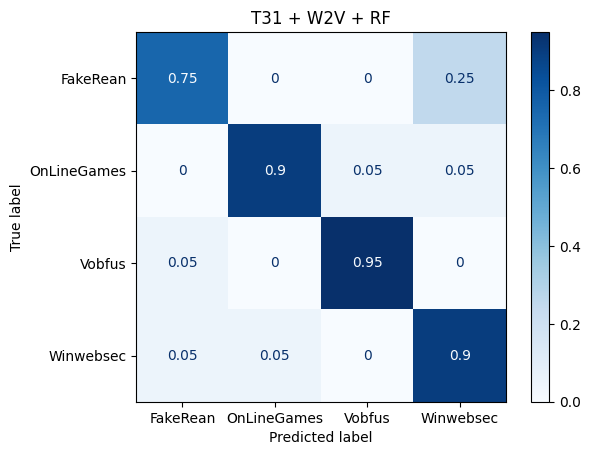

In [ ]:
# Single Word: M=31 + W2V
T31_rf_w2v, T31_rf_w2v_pred = fitRF(T31_train_w2v, T31_test_w2v, T31_y_train)
train_acc(T31_rf_w2v, T31_train_w2v, T31_y_train)
measures(T31_rf_w2v_pred, T31_y_test, 'T31 + W2V + RF')

##### Character BPE

train_accuracy: 100.0%
F1: 87.64%
Precision: 88.67%
Recall: 87.5%
Accuracy: 87.5%
[[15  0  0  5]
 [ 1 17  0  2]
 [ 0  0 20  0]
 [ 1  1  0 18]]


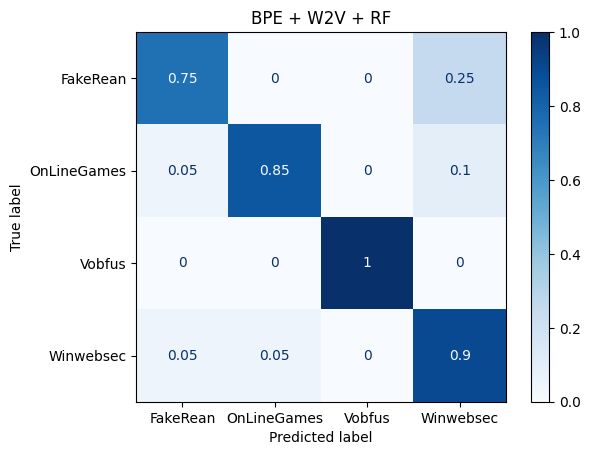

In [ ]:
# BPE + W2V
BPE_rf_w2v, BPE_rf_w2v_pred = fitRF(BPE_train_w2v, BPE_test_w2v, BPE_y_train)
train_acc(BPE_rf_w2v, BPE_train_w2v, BPE_y_train)
measures(BPE_rf_w2v_pred, BPE_y_test, 'BPE + W2V + RF')

#####WordPiece

train_accuracy: 100.0%
F1: 91.33%
Precision: 92.01%
Recall: 91.25%
Accuracy: 91.25%
[[16  0  0  4]
 [ 1 18  0  1]
 [ 0  0 20  0]
 [ 1  0  0 19]]


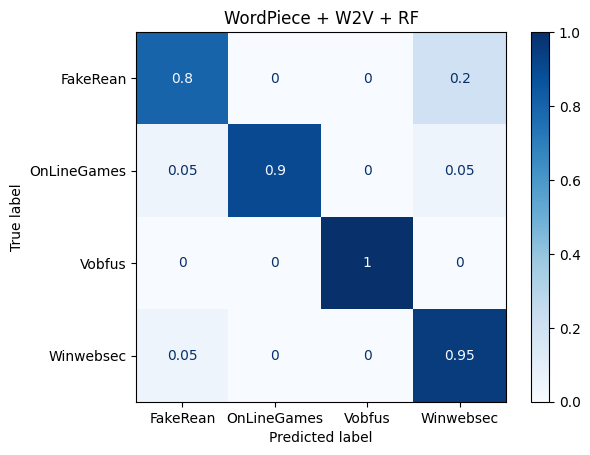

In [ ]:
# WPC + W2V
WPC_rf_w2v, WPC_rf_w2v_pred = fitRF(WPC_train_w2v, WPC_test_w2v, WPC_y_train)
train_acc(WPC_rf_w2v, WPC_train_w2v, WPC_y_train)
measures(WPC_rf_w2v_pred, WPC_y_test, 'WPC + W2V + RF')

#####SentencePiece

train_accuracy: 100.0%
F1: 91.42%
Precision: 92.53%
Recall: 91.25%
Accuracy: 91.25%
[[16  0  0  4]
 [ 0 18  0  2]
 [ 0  0 20  0]
 [ 1  0  0 19]]


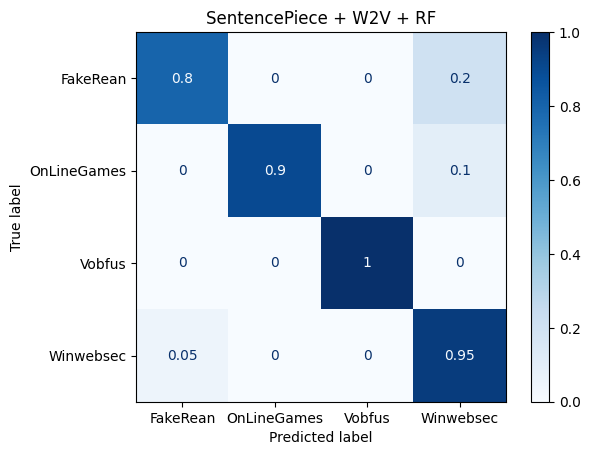

In [ ]:
# SPC + W2V
SPC_rf_w2v, SPC_rf_w2v_pred = fitRF(SPC_train_w2v, SPC_test_w2v, SPC_y_train)
train_acc(SPC_rf_w2v, SPC_train_w2v, SPC_y_train)
measures(SPC_rf_w2v_pred, SPC_y_test, 'SPC + W2V + RF')

#####Unigram Subword

train_accuracy: 100.0%
F1: 83.68%
Precision: 83.67%
Recall: 83.75%
Accuracy: 83.75%
[[16  2  0  2]
 [ 1 16  1  2]
 [ 1  0 19  0]
 [ 1  2  1 16]]


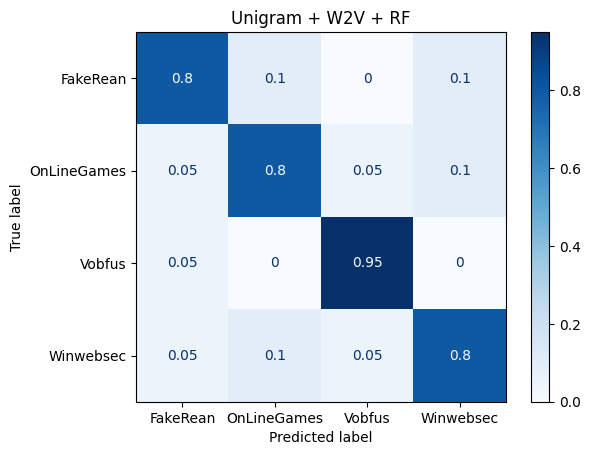

In [ ]:
# UNI + W2V
UNI_rf_w2v, UNI_rf_w2v_pred = fitRF(UNI_train_w2v, UNI_test_w2v, UNI_y_train)
train_acc(UNI_rf_w2v, UNI_train_w2v, UNI_y_train)
measures(UNI_rf_w2v_pred, UNI_y_test, 'UNI + W2V + RF')

####HMM2Vec

##### Single Words M=31

train_accuracy: 100.0%
F1: 83.96%
Precision: 85.87%
Recall: 83.75%
Accuracy: 83.75%
[[16  0  0  4]
 [ 4 14  0  2]
 [ 0  0 20  0]
 [ 3  0  0 17]]


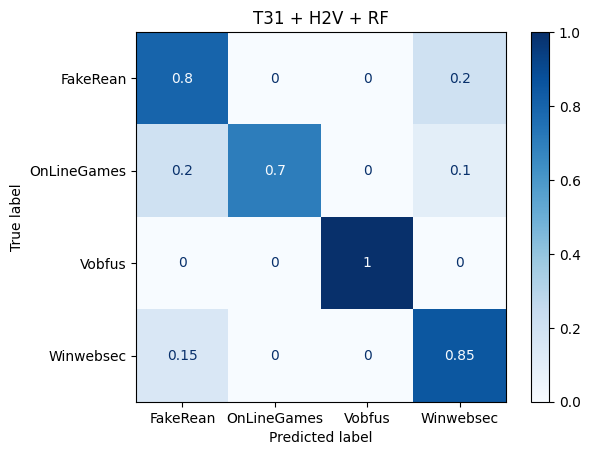

In [ ]:
# Single Word: M=31 + H2V
T31_rf_h2v, T31_rf_h2v_pred = fitRF(T31_train_h2v, T31_test_h2v, T31_y_train)
train_acc(T31_rf_h2v, T31_train_h2v, T31_y_train)
measures(T31_rf_h2v_pred, T31_y_test, 'T31 + H2V + RF')

#####BPE

train_accuracy: 100.0%
F1: 86.16%
Precision: 89.46%
Recall: 86.25%
Accuracy: 86.25%
[[16  0  0  4]
 [ 2 13  0  5]
 [ 0  0 20  0]
 [ 0  0  0 20]]


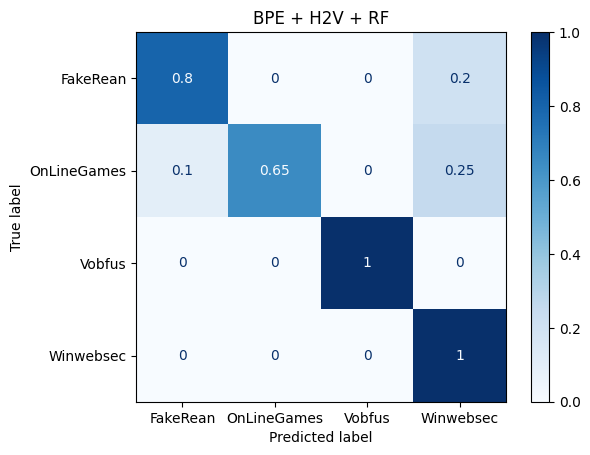

In [ ]:
# BPE + H2V
BPE_rf_h2v, BPE_rf_h2v_pred = fitRF(BPE_train_h2v, BPE_test_h2v, BPE_y_train)
train_acc(BPE_rf_h2v, BPE_train_h2v, BPE_y_train)
measures(BPE_rf_h2v_pred, BPE_y_test, 'BPE + H2V + RF')

##### WordPiece

train_accuracy: 100.0%
F1: 77.39%
Precision: 77.43%
Recall: 77.5%
Accuracy: 77.5%
[[15  1  2  2]
 [ 0 15  1  4]
 [ 0  2 18  0]
 [ 4  1  1 14]]


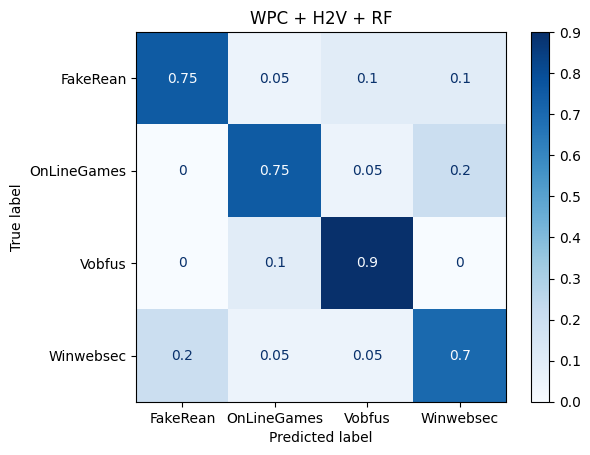

In [ ]:
# WPC + H2V
WPC_rf_h2v, WPC_rf_h2v_pred = fitRF(WPC_train_h2v, WPC_test_h2v, WPC_y_train)
train_acc(WPC_rf_h2v, WPC_train_h2v, WPC_y_train)
measures(WPC_rf_h2v_pred, WPC_y_test, 'WPC + H2V + RF')

#####SentencePiece

train_accuracy: 100.0%
F1: 77.24%
Precision: 79.01%
Recall: 77.5%
Accuracy: 77.5%
[[11  0  1  8]
 [ 1 17  0  2]
 [ 0  1 19  0]
 [ 1  3  1 15]]


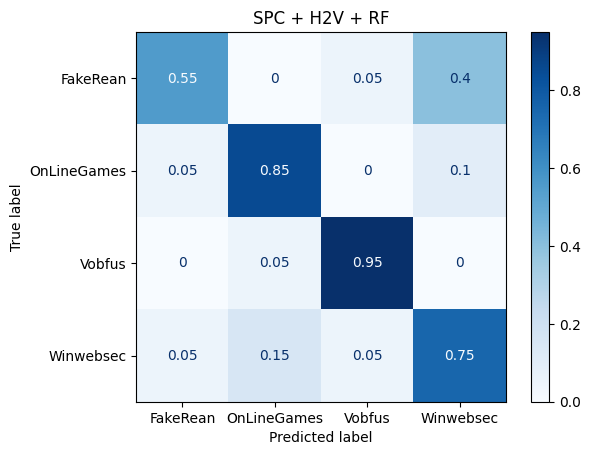

In [ ]:
# SPC + H2V
SPC_rf_h2v, SPC_rf_h2v_pred = fitRF(SPC_train_h2v, SPC_test_h2v, SPC_y_train)
train_acc(SPC_rf_h2v, SPC_train_h2v, SPC_y_train)
measures(SPC_rf_h2v_pred, SPC_y_test, 'SPC + H2V + RF')

#####Unigram Subword

train_accuracy: 100.0%
F1: 88.74%
Precision: 88.89%
Recall: 88.75%
Accuracy: 88.75%
[[17  0  1  2]
 [ 0 19  0  1]
 [ 1  1 18  0]
 [ 1  2  0 17]]


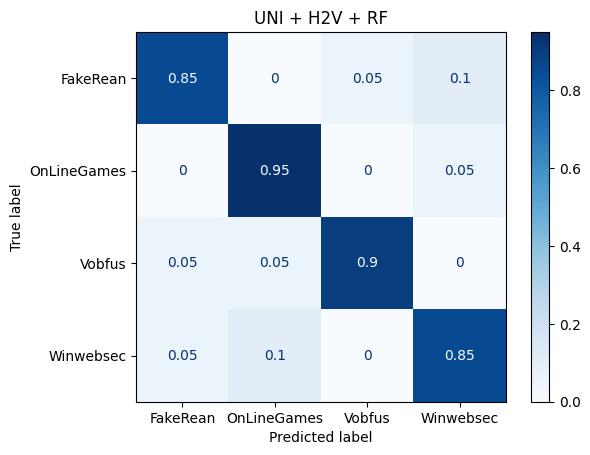

In [ ]:
# UNI + H2V
UNI_rf_h2v, UNI_rf_h2v_pred = fitRF(UNI_train_h2v, UNI_test_h2v, UNI_y_train)
train_acc(UNI_rf_h2v, UNI_train_h2v, UNI_y_train)
measures(UNI_rf_h2v_pred, UNI_y_test, 'UNI + H2V + RF')

####BERT

##### BPE

train_accuracy: 100.0%
F1: 88.85%
Precision: 89.38%
Recall: 88.75%
Accuracy: 88.75%
[[17  0  0  3]
 [ 2 17  1  0]
 [ 0  0 20  0]
 [ 3  0  0 17]]


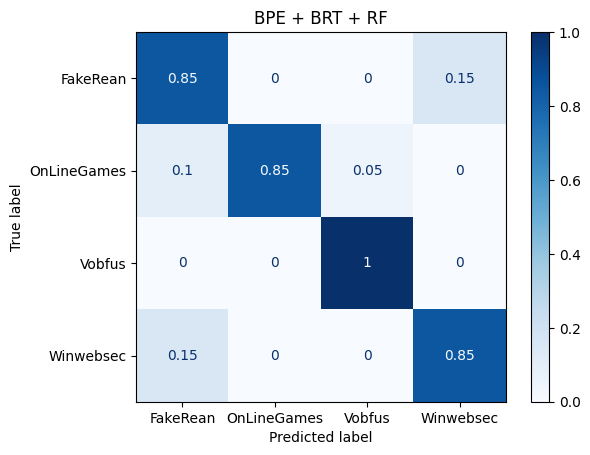

In [ ]:
# BPE + BERT
BPE_rf_brt, BPE_rf_brt_pred = fitRF(BPE_train_brt, BPE_test_brt, BPE_y_train)
train_acc(BPE_rf_brt, BPE_train_brt, BPE_y_train)
measures(BPE_rf_brt_pred, BPE_y_test, 'BPE + BRT + RF')

### KNN: K-Nearest Neighbors

In [ ]:
def fitKNN(train, test, y_train):
  clf = KNeighborsClassifier(n_neighbors=70)
  if type(train) == pd.Series:
    train = train.to_list()
    y_train = y_train.to_list()
    test = test.to_list()
  clf.fit(train, y_train)
  y_pred = clf.predict(test)
  return clf, y_pred

####Word2Vec

#####Single Words M=31

F1: 64.26%
Precision: 67.45%
Recall: 63.75%
Accuracy: 63.75%
[[14  3  0  3]
 [ 6 11  0  3]
 [ 0  9 11  0]
 [ 3  1  1 15]]


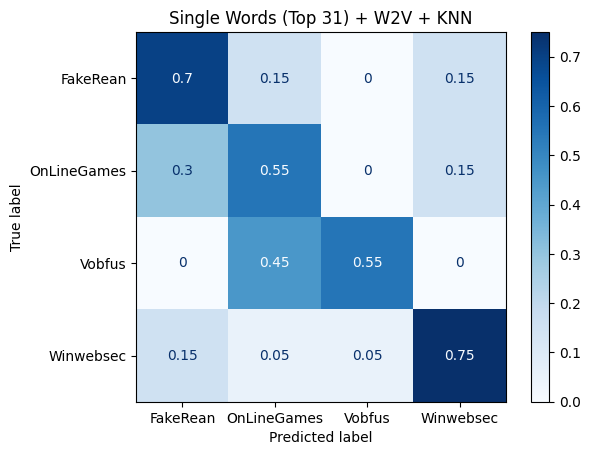

In [ ]:
# Single Words M=31 + W2V
T31_knn_w2v, T31_knn_w2v_pred = fitKNN(T31_train_w2v, T31_test_w2v, T31_y_train)
train_acc(T31_knn_w2v, T31_train_w2v, T31_y_train)
measures(T31_knn_w2v_pred, T31_y_test, 'T31 + W2V + KNN')

##### BPE: Byte Pair Encoding

F1: 54.62%
Precision: 58.91%
Recall: 53.75%
Accuracy: 53.75%
[[12  5  0  3]
 [ 7 11  0  2]
 [ 0  9 11  0]
 [ 8  1  2  9]]


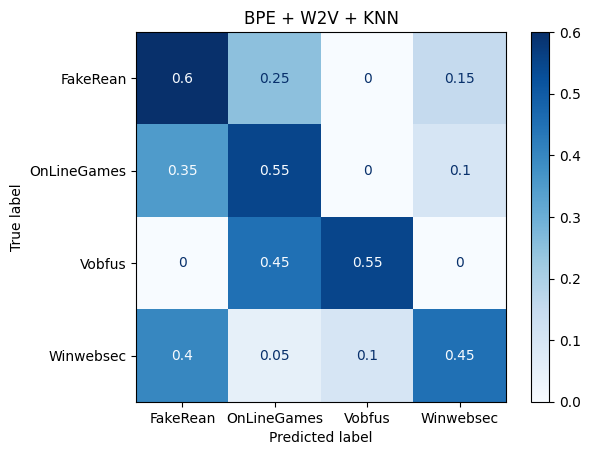

In [ ]:
# BPE + W2V
BPE_knn_w2v, BPE_knn_w2v_pred = fitKNN(BPE_train_w2v, BPE_test_w2v, BPE_y_train)
train_acc(BPE_knn_w2v, BPE_train_w2v, BPE_y_train)
measures(BPE_knn_w2v_pred, BPE_y_test, 'BPE + W2V + KNN')

#####WordPiece

F1: 57.32%
Precision: 61.24%
Recall: 56.25%
Accuracy: 56.25%
[[11  5  0  4]
 [ 6 11  0  3]
 [ 0  9 11  0]
 [ 6  1  1 12]]


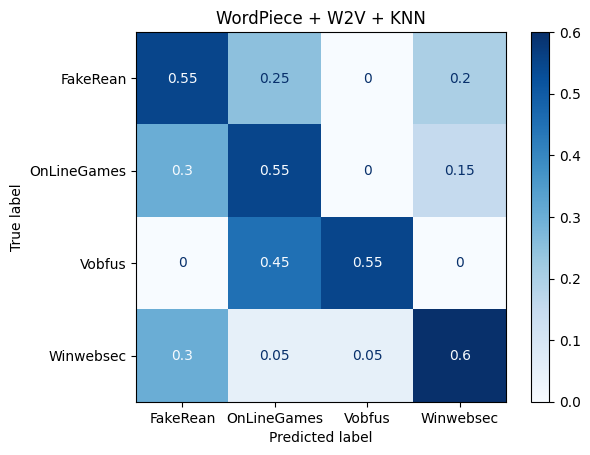

In [ ]:
# WPC + w2v
WPC_knn_w2v, WPC_knn_w2v_pred = fitKNN(WPC_train_w2v, WPC_test_w2v, WPC_y_train)
train_acc(WPC_knn_w2v, WPC_train_w2v, WPC_y_train)
measures(WPC_knn_w2v_pred, WPC_y_test, 'WPC + W2V + KNN')

#####SentencePiece

F1: 59.91%
Precision: 64.7%
Recall: 58.75%
Accuracy: 58.75%
[[13  4  0  3]
 [ 8 11  0  1]
 [ 0  9 11  0]
 [ 6  1  1 12]]


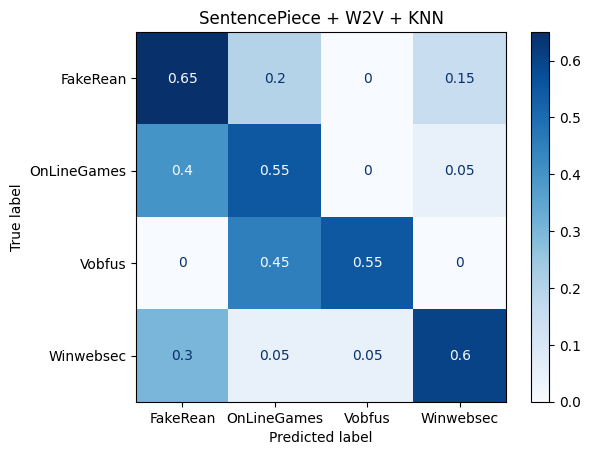

In [ ]:
# SPC + W2V
SPC_knn_w2v, SPC_knn_w2v_pred = fitKNN(SPC_train_w2v, SPC_test_w2v, SPC_y_train)
train_acc(SPC_knn_w2v, SPC_train_w2v, SPC_y_train)
measures(SPC_knn_w2v_pred, SPC_y_test, 'SPC + W2V + KNN')

#####Unigram Subword

In [ ]:
# UNI + W2V
UNI_knn_w2v, UNI_knn_w2v_pred = fitKNN(UNI_train_w2v, UNI_test_w2v, UNI_y_train)
train_acc(UNI_knn_w2v, UNI_train_w2v, UNI_y_train)
measures(UNI_knn_w2v_pred, UNI_y_test, 'UNI + W2V + KNN')

NameError: name 'UNI_train_w2v' is not defined

####HMM2Vec

#####Single Words M=31

train_accuracy: 54.06%
F1: 54.12%
Precision: 61.21%
Recall: 53.75%
Accuracy: 53.75%
[[13  3  1  3]
 [ 6 12  0  2]
 [ 0 12  8  0]
 [ 9  1  0 10]]


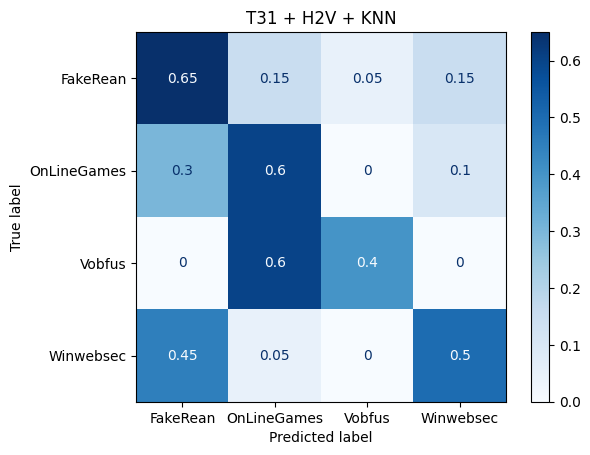

In [ ]:
# Single Words M=31 + H2V
T31_knn_h2v, T31_knn_h2v_pred = fitKNN(T31_train_h2v, T31_test_h2v, T31_y_train)
train_acc(T31_knn_h2v, T31_train_h2v, T31_y_train)
measures(T31_knn_h2v_pred, T31_y_test, 'T31 + H2V + KNN')

##### BPE: Byte Pair Encoding

train_accuracy: 56.88%
F1: 58.04%
Precision: 64.14%
Recall: 57.5%
Accuracy: 57.5%
[[15  3  0  2]
 [ 7 11  0  2]
 [ 1  9 10  0]
 [ 8  1  1 10]]


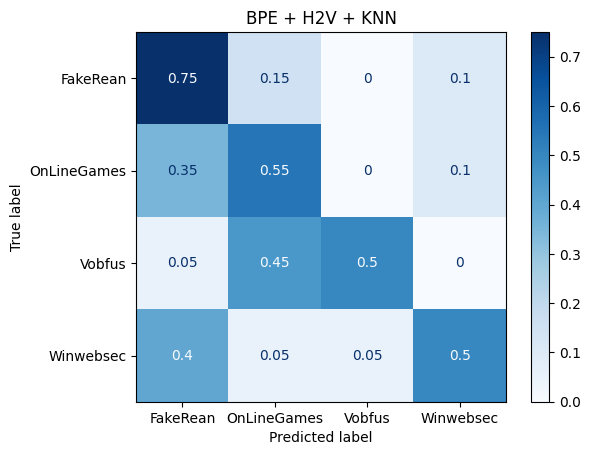

In [ ]:
# BPE + H2V
BPE_knn_h2v, BPE_knn_h2v_pred = fitKNN(BPE_train_h2v, BPE_test_h2v, BPE_y_train)
train_acc(BPE_knn_h2v, BPE_train_h2v, BPE_y_train)
measures(BPE_knn_h2v_pred, BPE_y_test, 'BPE + H2V + KNN')

##### WordPiece

train_accuracy: 54.69%
F1: 54.03%
Precision: 55.81%
Recall: 53.75%
Accuracy: 53.75%
[[ 8  8  2  2]
 [ 4 12  3  1]
 [ 1  6 12  1]
 [ 4  2  3 11]]


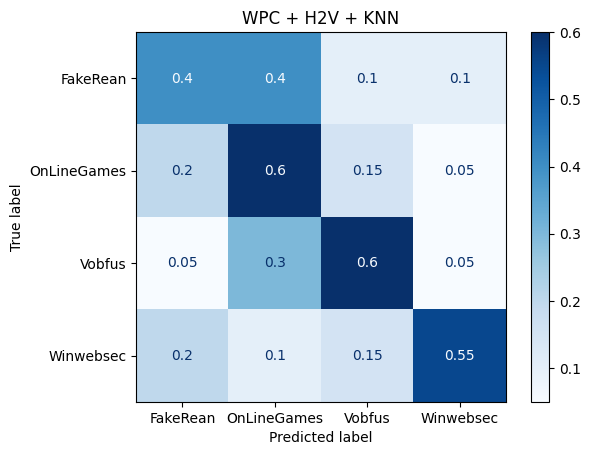

In [ ]:
# WPC + H2V
WPC_knn_h2v, WPC_knn_h2v_pred = fitKNN(WPC_train_h2v, WPC_test_h2v, WPC_y_train)
train_acc(WPC_knn_h2v, WPC_train_h2v, WPC_y_train)
measures(WPC_knn_h2v_pred, WPC_y_test, 'WPC + H2V + KNN')

#####SentencePiece

train_accuracy: 37.5%
F1: 34.89%
Precision: 51.94%
Recall: 41.25%
Accuracy: 41.25%
[[ 1  3 15  1]
 [ 1 10  9  0]
 [ 0  1 19  0]
 [ 1  1 15  3]]


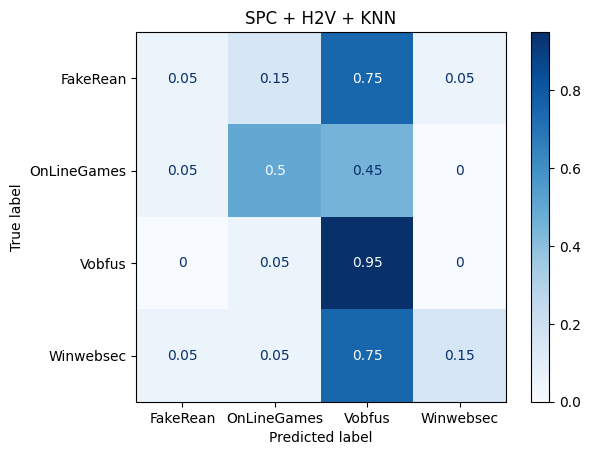

In [ ]:
# SPC + H2V
SPC_knn_h2v, SPC_knn_h2v_pred = fitKNN(SPC_train_h2v, SPC_test_h2v, SPC_y_train)
train_acc(SPC_knn_h2v, SPC_train_h2v, SPC_y_train)
measures(SPC_knn_h2v_pred, SPC_y_test, 'SPC + H2V + KNN')

#####Unigram Subword

train_accuracy: 54.37%
F1: 47.68%
Precision: 55.52%
Recall: 47.5%
Accuracy: 47.5%
[[ 6  4  0 10]
 [ 6 11  0  3]
 [ 0 10  8  2]
 [ 6  1  0 13]]


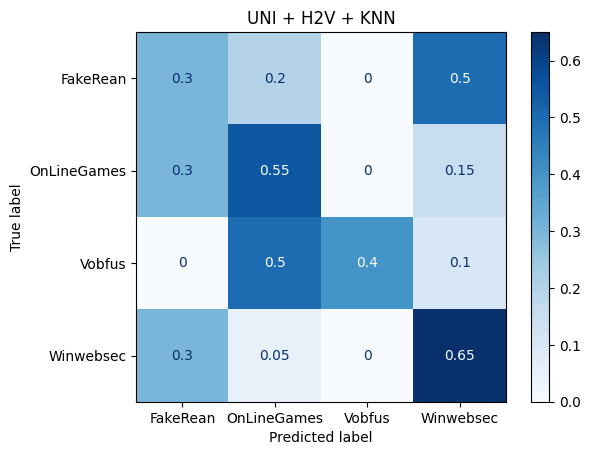

In [ ]:
# UNI + H2V
UNI_knn_h2v, UNI_knn_h2v_pred = fitKNN(UNI_train_h2v, UNI_test_h2v, UNI_y_train)
train_acc(UNI_knn_h2v, UNI_train_h2v, UNI_y_train)
measures(UNI_knn_h2v_pred, UNI_y_test, 'UNI + H2V + KNN')

####BERT

##### BPE

In [ ]:
# BPE + BERT
BPE_knn_brt, BPE_knn_brt_pred = fitKNN(BPE_train_brt, BPE_test_brt, BPE_y_train)
train_acc(BPE_knn_brt, BPE_train_brt, BPE_y_train)
measures(BPE_knn_brt_pred, BPE_y_test, 'BPE + BRT + KNN')

NameError: name 'BPE_train_brt' is not defined

###SVM: Support Vector Machine###

In [ ]:
# REMEMBER TO CHANGE W2V embedding window=10, vector_size=31
def fitSVM(train, test, y_train, svm_type):
    clf = SVC(kernel=svm_type)
    if type(train) == pd.Series:
      train = train.to_list()
      y_train = y_train.to_list()
      test = test.to_list()
    clf.fit(train, y_train)
    y_pred = clf.predict(test)
    return clf, y_pred

####RBF SVM

#####Word2Vec

###### Single Words M=31

F1: 78.37%
Precision: 80.05%
Recall: 78.75%
Accuracy: 78.75%
[[16  0  0  4]
 [ 6 11  1  2]
 [ 0  1 19  0]
 [ 2  1  0 17]]


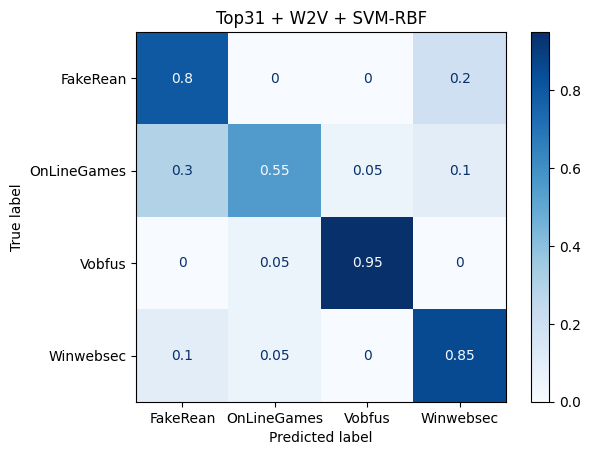

In [ ]:
# Single Words M=31; RBF SVM + W2V
T31_svm_w2v_rbf, T31_svm_w2v_pred_rbf = fitSVM(T31_train_w2v, T31_test_w2v, T31_y_train, 'rbf')
train_acc(T31_svm_w2v_rbf, T31_train_w2v, T31_y_train)
measures(T31_svm_w2v_pred_rbf, T31_y_test, 'T31 + W2V + SVM-RBF')

######BPE

F1: 78.77%
Precision: 80.44%
Recall: 78.75%
Accuracy: 78.75%
[[15  0  0  5]
 [ 6 12  0  2]
 [ 0  1 19  0]
 [ 2  1  0 17]]


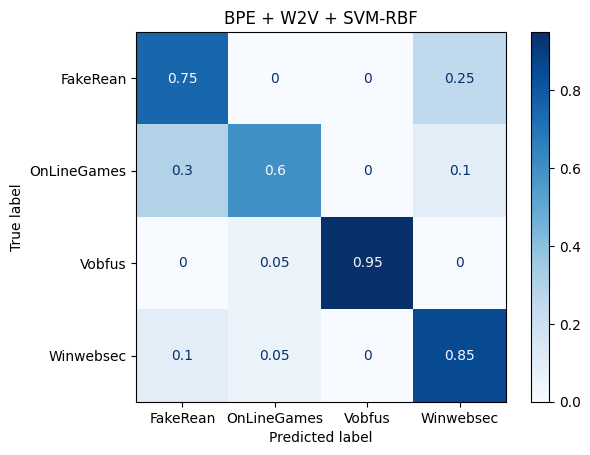

In [ ]:
# BPE + W2V
BPE_svm_w2v_rbf, BPE_svm_w2v_pred_rbf = fitSVM(BPE_train_w2v, BPE_test_w2v, BPE_y_train, 'rbf')
train_acc(BPE_svm_w2v_rbf, BPE_train_w2v, BPE_y_train)
measures(BPE_svm_w2v_pred_rbf, BPE_y_test, 'BPE + W2V + SVM-RBF')

######WordPiece

F1: 79.66%
Precision: 81.57%
Recall: 80.0%
Accuracy: 80.0%
[[17  0  0  3]
 [ 5 11  0  4]
 [ 0  1 19  0]
 [ 2  1  0 17]]


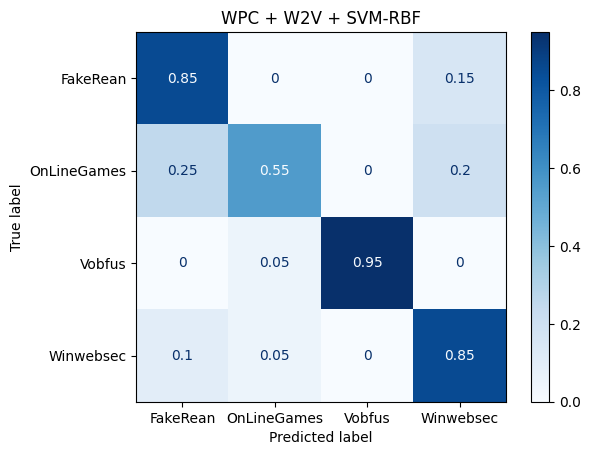

In [ ]:
# WPC + W2V
WPC_svm_w2v_rbf, WPC_svm_w2v_pred_rbf = fitSVM(WPC_train_w2v, WPC_test_w2v, WPC_y_train, 'rbf')
train_acc(WPC_svm_w2v_rbf, WPC_train_w2v, WPC_y_train)
measures(WPC_svm_w2v_pred_rbf, WPC_y_test, 'WPC + W2V + SVM-RBF')

######SentencePiece

F1: 83.63%
Precision: 84.71%
Recall: 83.75%
Accuracy: 83.75%
[[17  0  0  3]
 [ 5 13  0  2]
 [ 0  1 19  0]
 [ 1  1  0 18]]


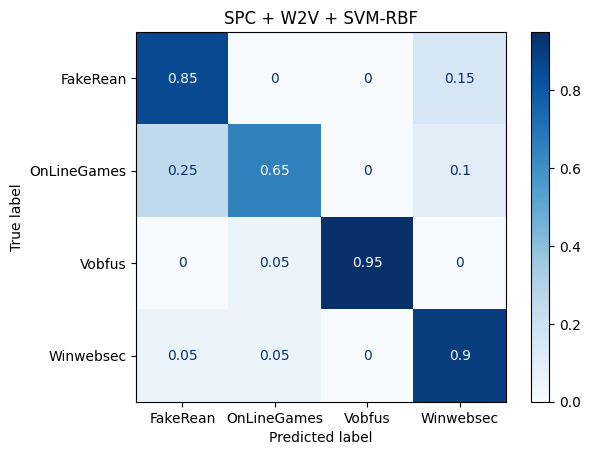

In [ ]:
# SPC + W2V
SPC_svm_w2v_rbf, SPC_svm_w2v_pred_rbf = fitSVM(SPC_train_w2v, SPC_test_w2v, SPC_y_train, 'rbf')
train_acc(SPC_svm_w2v_rbf, SPC_train_w2v, SPC_y_train)
measures(SPC_svm_w2v_pred_rbf, SPC_y_test, 'SPC + W2V + SVM-RBF')

######Unigram Subword

F1: 82.43%
Precision: 83.6%
Recall: 82.5%
Accuracy: 82.5%
[[16  0  0  4]
 [ 5 13  0  2]
 [ 0  1 19  0]
 [ 1  1  0 18]]


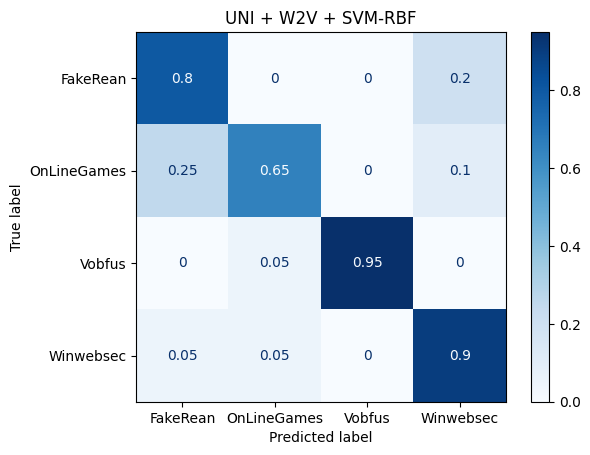

In [ ]:
# UNI + W2V
UNI_svm_w2v_rbf, UNI_svm_w2v_pred_rbf = fitSVM(UNI_train_w2v, UNI_test_w2v, UNI_y_train, 'rbf')
train_acc(UNI_svm_w2v_rbf, UNI_train_w2v, UNI_y_train)
measures(UNI_svm_w2v_pred_rbf, UNI_y_test, 'UNI + W2V + SVM-RBF')

#####HMM2Vec

######Single Words M=31

train_accuracy: 88.44%
F1: 78.9%
Precision: 79.69%
Recall: 78.75%
Accuracy: 78.75%
[[16  1  0  3]
 [ 4 13  0  3]
 [ 0  2 18  0]
 [ 3  1  0 16]]


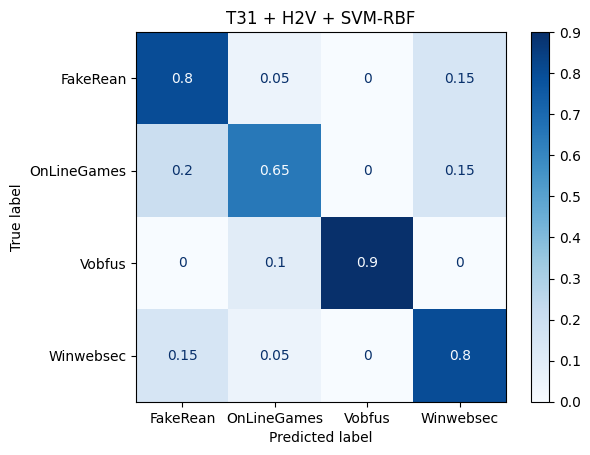

In [ ]:
# Single Words M=31; RBF SVM + H2V
T31_svm_h2v_rbf, T31_svm_h2v_pred_rbf = fitSVM(T31_train_h2v, T31_test_h2v, T31_y_train, 'rbf')
train_acc(T31_svm_h2v_rbf, T31_train_h2v, T31_y_train)
measures(T31_svm_h2v_pred_rbf, T31_y_test, 'T31 + H2V + SVM-RBF')

######BPE

train_accuracy: 75.94%
F1: 67.5%
Precision: 70.47%
Recall: 67.5%
Accuracy: 67.5%
[[14  2  0  4]
 [ 9  8  0  3]
 [ 1  1 17  1]
 [ 4  1  0 15]]


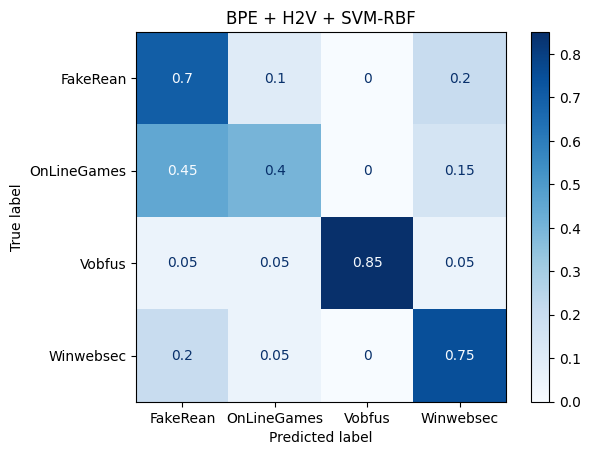

In [ ]:
# BPE + H2V
BPE_svm_h2v_rbf, BPE_svm_h2v_pred_rbf = fitSVM(BPE_train_h2v, BPE_test_h2v, BPE_y_train, 'rbf')
train_acc(BPE_svm_h2v_rbf, BPE_train_h2v, BPE_y_train)
measures(BPE_svm_h2v_pred_rbf, BPE_y_test, 'BPE + H2V + SVM-RBF')

######WordPiece

train_accuracy: 73.44%
F1: 62.33%
Precision: 62.94%
Recall: 62.5%
Accuracy: 62.5%
[[10  5  0  5]
 [ 1 12  3  4]
 [ 1  3 15  1]
 [ 3  1  3 13]]


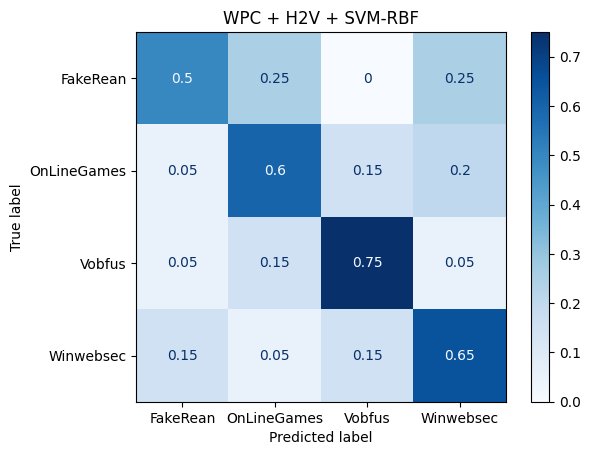

In [ ]:
# WPC + H2V
WPC_svm_h2v_rbf, WPC_svm_h2v_pred_rbf = fitSVM(WPC_train_h2v, WPC_test_h2v, WPC_y_train, 'rbf')
train_acc(WPC_svm_h2v_rbf, WPC_train_h2v, WPC_y_train)
measures(WPC_svm_h2v_pred_rbf, WPC_y_test, 'WPC + H2V + SVM-RBF')

######SentencePiece

train_accuracy: 73.12%
F1: 65.45%
Precision: 66.78%
Recall: 66.25%
Accuracy: 66.25%
[[ 8  5  3  4]
 [ 3 16  0  1]
 [ 0  3 16  1]
 [ 2  4  1 13]]


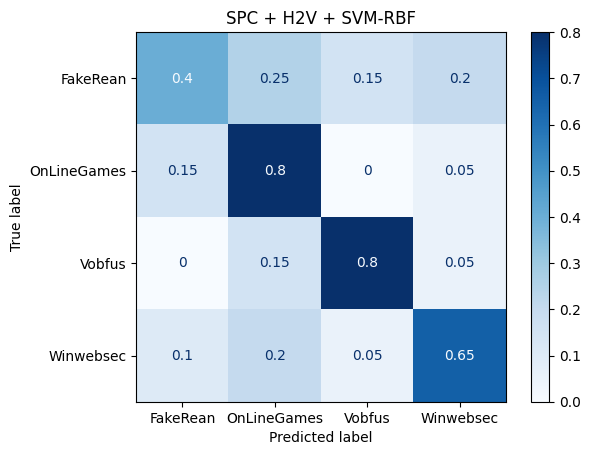

In [ ]:
# SPC + H2V
SPC_svm_h2v_rbf, SPC_svm_h2v_pred_rbf = fitSVM(SPC_train_h2v, SPC_test_h2v, SPC_y_train, 'rbf')
train_acc(SPC_svm_h2v_rbf, SPC_train_h2v, SPC_y_train)
measures(SPC_svm_h2v_pred_rbf, SPC_y_test, 'SPC + H2V + SVM-RBF')

######Unigram Subword

train_accuracy: 75.94%
F1: 71.41%
Precision: 71.8%
Recall: 71.25%
Accuracy: 71.25%
[[14  1  0  5]
 [ 6 13  1  0]
 [ 1  3 16  0]
 [ 2  2  2 14]]


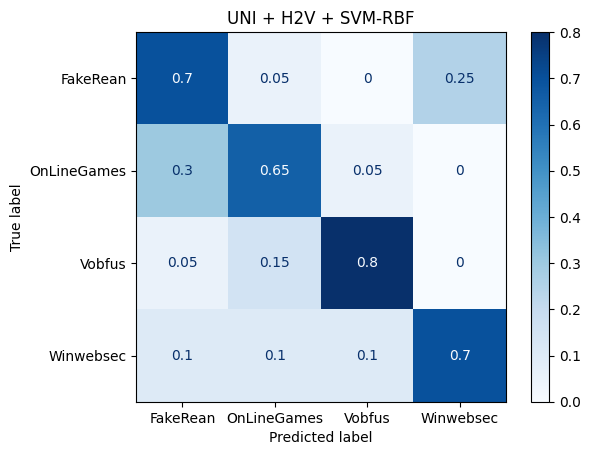

In [ ]:
# UNI + H2V
UNI_svm_h2v_rbf, UNI_svm_h2v_pred_rbf = fitSVM(UNI_train_h2v, UNI_test_h2v, UNI_y_train, 'rbf')
train_acc(UNI_svm_h2v_rbf, UNI_train_h2v, UNI_y_train)
measures(UNI_svm_h2v_pred_rbf, UNI_y_test, 'UNI + H2V + SVM-RBF')

####Linear SVM

#####Word2Vec

######Single Words M=31

F1: 92.38%
Precision: 92.68%
Recall: 92.5%
Accuracy: 92.5%
[[19  0  0  1]
 [ 1 19  0  0]
 [ 0  0 20  0]
 [ 2  1  1 16]]


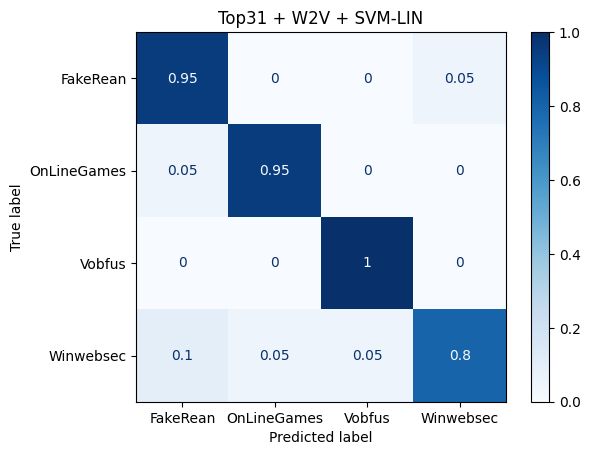

In [ ]:
# Single Words M=31; LIN SVM + W2V
T31_svm_w2v_lin, T31_svm_w2v_pred_lin = fitSVM(T31_train_w2v, T31_test_w2v, T31_y_train, 'linear')
train_acc(T31_svm_w2v_lin, T31_train_w2v, T31_y_train)
measures(T31_svm_w2v_pred_lin, T31_y_test, 'T31 + W2V + SVM-LIN')

###### BPE

F1: 87.55%
Precision: 87.74%
Recall: 87.5%
Accuracy: 87.5%
[[17  1  0  2]
 [ 2 17  0  1]
 [ 0  0 20  0]
 [ 3  1  0 16]]


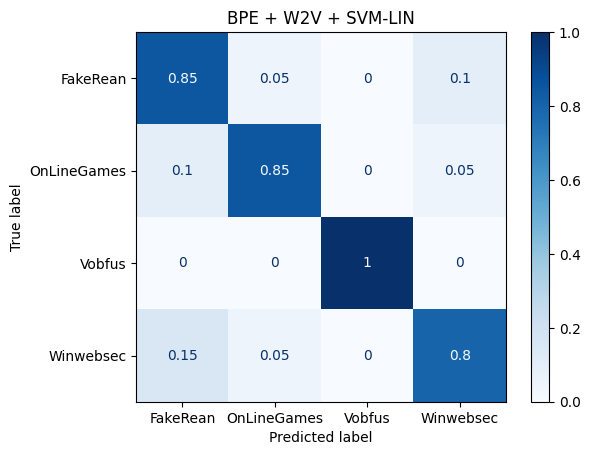

In [ ]:
# BPE + W2V
BPE_svm_w2v_lin, BPE_svm_w2v_pred_lin = fitSVM(BPE_train_w2v, BPE_test_w2v, BPE_y_train, 'linear')
train_acc(BPE_svm_w2v_lin, BPE_train_w2v, BPE_y_train)
measures(BPE_svm_w2v_pred_lin, BPE_y_test, 'BPE + W2V + SVM-LIN')

######WordPiece

F1: 83.75%
Precision: 84.25%
Recall: 83.75%
Accuracy: 83.75%
[[18  0  0  2]
 [ 2 16  0  2]
 [ 0  1 19  0]
 [ 4  2  0 14]]


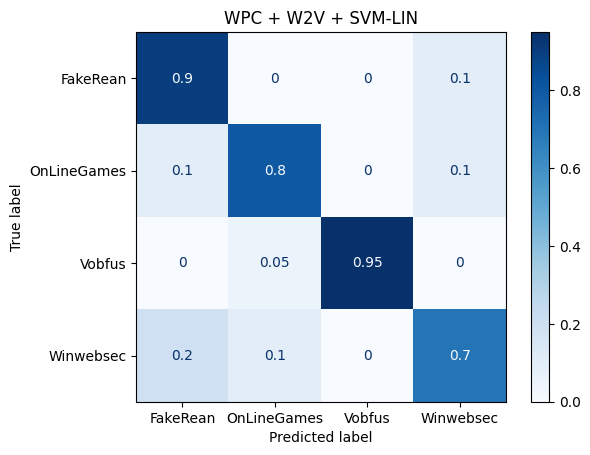

In [ ]:
# WPC + W2V
WPC_svm_w2v_lin, WPC_svm_w2v_pred_lin = fitSVM(WPC_train_w2v, WPC_test_w2v, WPC_y_train, 'linear')
train_acc(WPC_svm_w2v_lin, WPC_train_w2v, WPC_y_train)
measures(WPC_svm_w2v_pred_lin, WPC_y_test, 'WPC + W2V + SVM-LIN')

######SentencePiece

F1: 86.37%
Precision: 86.83%
Recall: 86.25%
Accuracy: 86.25%
[[17  0  0  3]
 [ 2 17  0  1]
 [ 0  0 20  0]
 [ 4  1  0 15]]


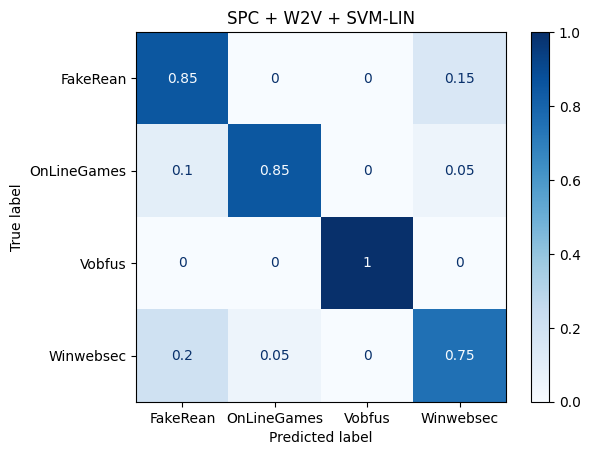

In [ ]:
# SPC + W2V
SPC_svm_w2v_lin, SPC_svm_w2v_pred_lin = fitSVM(SPC_train_w2v, SPC_test_w2v, SPC_y_train, 'linear')
train_acc(SPC_svm_w2v_lin, SPC_train_w2v, SPC_y_train)
measures(SPC_svm_w2v_pred_lin, SPC_y_test, 'SPC + W2V + SVM-LIN')

######Unigram Subword

F1: 90.06%
Precision: 90.17%
Recall: 90.0%
Accuracy: 90.0%
[[17  0  0  3]
 [ 1 18  0  1]
 [ 0  0 20  0]
 [ 2  1  0 17]]


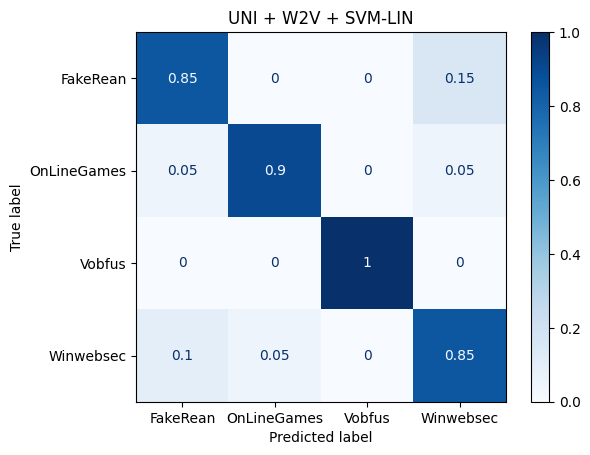

In [ ]:
# UNI + W2V
UNI_svm_w2v_lin, UNI_svm_w2v_pred_lin = fitSVM(UNI_train_w2v, UNI_test_w2v, UNI_y_train, 'linear')
train_acc(UNI_svm_w2v_lin, UNI_train_w2v, UNI_y_train)
measures(UNI_svm_w2v_pred_lin, UNI_y_test, 'UNI + W2V + SVM-LIN')

#####HMM2Vec

######Single Words M=31

train_accuracy: 65.31%
F1: 58.84%
Precision: 64.62%
Recall: 58.75%
Accuracy: 58.75%
[[ 8  3  0  9]
 [ 3 12  0  5]
 [ 0  9 11  0]
 [ 3  1  0 16]]


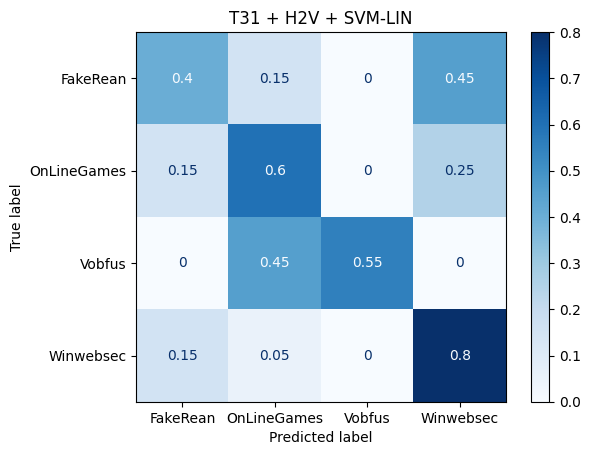

In [ ]:
# Single Words M=31; LIN SVM + H2V
T31_svm_h2v_lin, T31_svm_h2v_pred_lin = fitSVM(T31_train_h2v, T31_test_h2v, T31_y_train, 'linear')
train_acc(T31_svm_h2v_lin, T31_train_h2v, T31_y_train)
measures(T31_svm_h2v_pred_lin, T31_y_test, 'T31 + H2V + SVM-LIN')

######BPE

train_accuracy: 52.81%
F1: 51.63%
Precision: 62.65%
Recall: 51.25%
Accuracy: 51.25%
[[15  3  0  2]
 [ 9 10  0  1]
 [ 2  8 10  0]
 [13  1  0  6]]


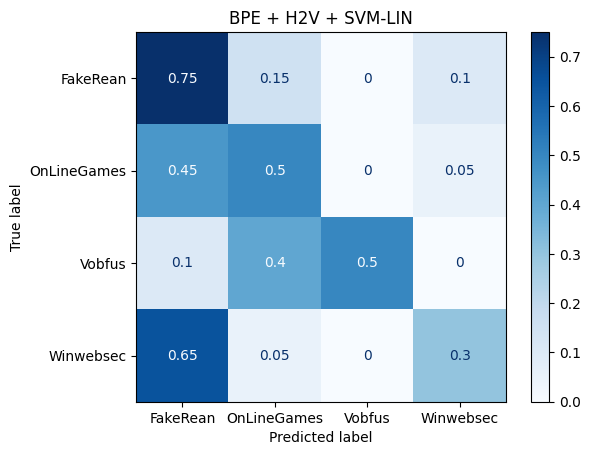

In [ ]:
# BPE + H2V
BPE_svm_h2v_lin, BPE_svm_h2v_pred_lin = fitSVM(BPE_train_h2v, BPE_test_h2v, BPE_y_train, 'linear')
train_acc(BPE_svm_h2v_lin, BPE_train_h2v, BPE_y_train)
measures(BPE_svm_h2v_pred_lin, BPE_y_test, 'BPE + H2V + SVM-LIN')

######WordPiece

train_accuracy: 52.19%
F1: 47.55%
Precision: 52.87%
Recall: 48.75%
Accuracy: 48.75%
[[10  5  0  5]
 [ 4 12  0  4]
 [ 3  6  5  6]
 [ 4  2  2 12]]


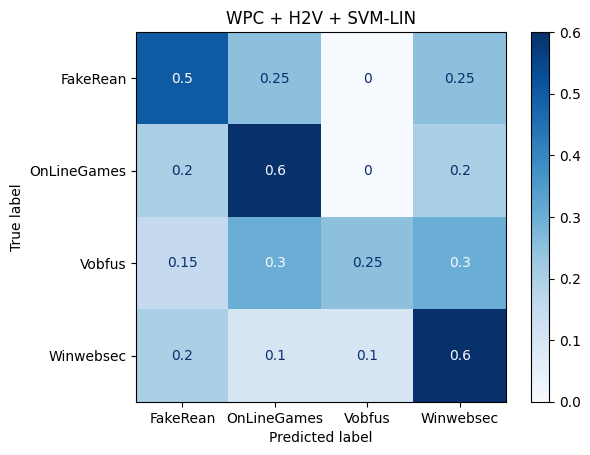

In [ ]:
# WPC + H2V
WPC_svm_h2v_lin, WPC_svm_h2v_pred_lin = fitSVM(WPC_train_h2v, WPC_test_h2v, WPC_y_train, 'linear')
train_acc(WPC_svm_h2v_lin, WPC_train_h2v, WPC_y_train)
measures(WPC_svm_h2v_pred_lin, WPC_y_test, 'WPC + H2V + SVM-LIN')

######SentencePiece

train_accuracy: 36.88%
F1: 29.58%
Precision: 46.81%
Recall: 38.75%
Accuracy: 38.75%
[[ 0  2  0 18]
 [ 0 10  0 10]
 [ 0  5  2 13]
 [ 0  1  0 19]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


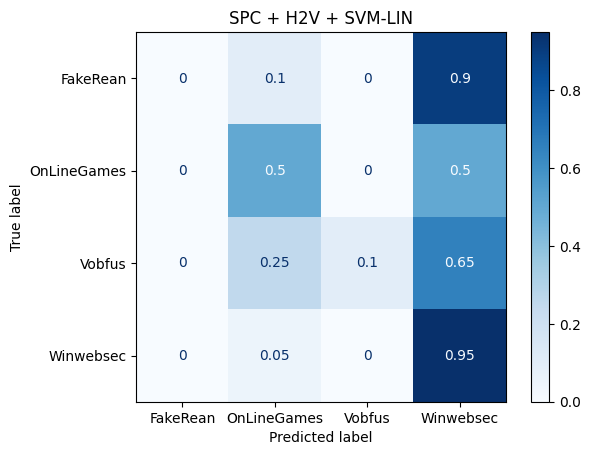

In [ ]:
# SPC + H2V
SPC_svm_h2v_lin, SPC_svm_h2v_pred_lin = fitSVM(SPC_train_h2v, SPC_test_h2v, SPC_y_train, 'linear')
train_acc(SPC_svm_h2v_lin, SPC_train_h2v, SPC_y_train)
measures(SPC_svm_h2v_pred_lin, SPC_y_test, 'SPC + H2V + SVM-LIN')

######Unigram Subword

train_accuracy: 51.88%
F1: 48.02%
Precision: 60.41%
Recall: 50.0%
Accuracy: 50.0%
[[ 4  3  0 13]
 [ 1 12  0  7]
 [ 0 11  8  1]
 [ 1  2  1 16]]


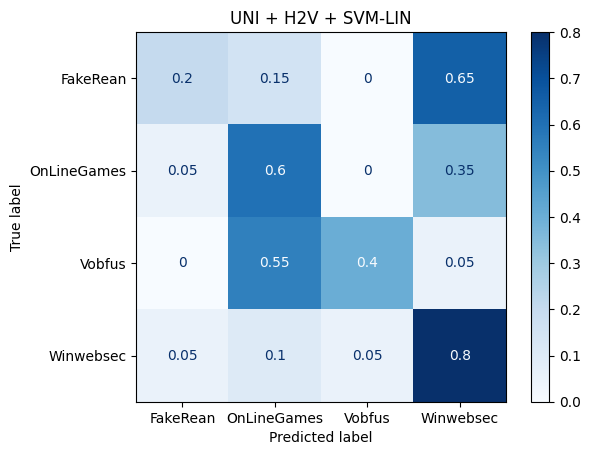

In [ ]:
# UNI + H2V
UNI_svm_h2v_lin, UNI_svm_h2v_pred_lin = fitSVM(UNI_train_h2v, UNI_test_h2v, UNI_y_train, 'linear')
train_acc(UNI_svm_h2v_lin, UNI_train_h2v, UNI_y_train)
measures(UNI_svm_h2v_pred_lin, UNI_y_test, 'UNI + H2V + SVM-LIN')

### CNN

In [141]:
e = 5 # num of epochs
val = 0.1 # validation split
lr = 0.001 # learning rate

# CNN: Data 80/10/10 train/val/test split
# input layer dim=200 (100x2); hidden=500, output=7
# train 50 epochs, MSE loss, Adam optimizer, dropout 0.5
# learning rate = 0.001
# beta1 = 0.9; beta2 = 0.999; whatever that means
# N (vector size)=100, Window=5 for w2v

def fitCNN(train, test, y_train):
  '''
  y_train labels must be onehot encoded
  '''
  v_size = len(train[0])
  # define CNN layers
  model = models.Sequential([
    layers.Input(shape=(v_size, (1))),
    layers.Conv1D(500, (1), activation='relu'),
    layers.Dropout(0.5),
    # change int val to num of families!
    layers.Flatten(),
    layers.Dense(4, activation='softmax')
    ])
  # compile model
  opt = optimizers.Adam(learning_rate=lr)
  model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
  model.summary()
  # fit model on train data & obtain test predictions
  ohe = OneHotEncoder(sparse_output=False).fit(y_train.to_numpy().reshape(-1,1))
  y_train = ohe.transform(y_train.to_numpy().reshape(-1,1))
  model.fit(np.vstack(train), np.vstack(y_train), epochs=e, validation_split=val)

  y_pred = model.predict(np.vstack(test))
  y_pred = ohe.inverse_transform(y_pred).flatten()
  return model, y_pred

####Word2Vec

#####Single Words M=31

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_37 (Conv1D)          (None, 100, 500)          1000      
                                                                 
 dropout_37 (Dropout)        (None, 100, 500)          0         
                                                                 
 flatten_18 (Flatten)        (None, 50000)             0         
                                                                 
 dense_38 (Dense)            (None, 4)                 200004    
                                                                 
Total params: 201004 (785.17 KB)
Trainable params: 201004 (785.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
9/9 [==============================] - 3s 137ms/step - loss: 0.1484 - accuracy: 0.5243 - val_loss: 0.1185 - val_accuracy: 0.7188
Epoch 

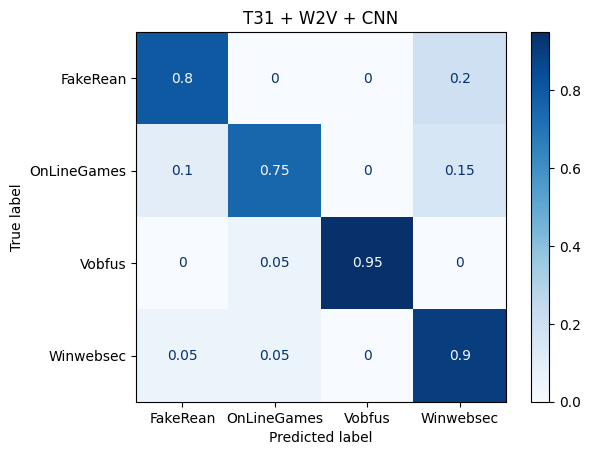

In [142]:
T31_cnn_w2v, T31_cnn_w2v_pred = fitCNN(T31_train_w2v, T31_test_w2v, T31_y_train)
measures(T31_cnn_w2v_pred, T31_y_test, 'T31 + W2V + CNN')

#####BPE

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_45 (Conv1D)          (None, 100, 500)          1000      
                                                                 
 dropout_45 (Dropout)        (None, 100, 500)          0         
                                                                 
 flatten_26 (Flatten)        (None, 50000)             0         
                                                                 
 dense_46 (Dense)            (None, 4)                 200004    
                                                                 
Total params: 201004 (785.17 KB)
Trainable params: 201004 (785.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
9/9 [==============================] - 1s 55ms/step - loss: 0.1534 - accuracy: 0.5208 - val_loss: 0.1255 - val_accuracy: 0.5625
Epoch 2

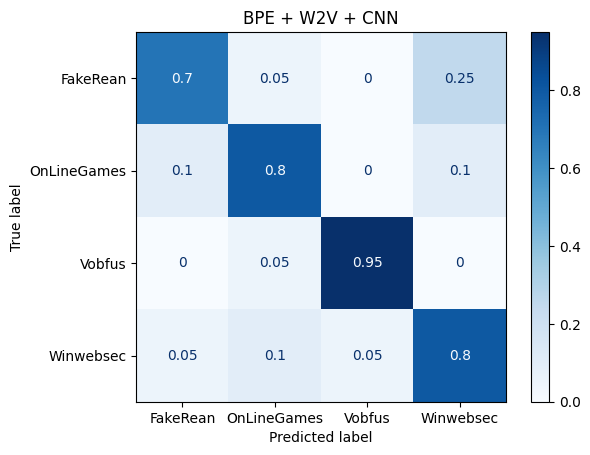

In [150]:
BPE_cnn_w2v, BPE_cnn_w2v_pred = fitCNN(BPE_train_w2v, BPE_test_w2v, BPE_y_train)
measures(BPE_cnn_w2v_pred, BPE_y_test, 'BPE + W2V + CNN')

#####WordPiece

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_39 (Conv1D)          (None, 100, 500)          1000      
                                                                 
 dropout_39 (Dropout)        (None, 100, 500)          0         
                                                                 
 flatten_20 (Flatten)        (None, 50000)             0         
                                                                 
 dense_40 (Dense)            (None, 4)                 200004    
                                                                 
Total params: 201004 (785.17 KB)
Trainable params: 201004 (785.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
9/9 [==============================] - 2s 88ms/step - loss: 0.1515 - accuracy: 0.5556 - val_loss: 0.1367 - val_accuracy: 0.5625
Epoch 2

3/3 [==============================] - 0s 12ms/step
F1: 82.62%
Precision: 83.54%
Recall: 82.5%
Accuracy: 82.5%
[[16  0  0  4]
 [ 4 14  0  2]
 [ 0  1 19  0]
 [ 2  1  0 17]]


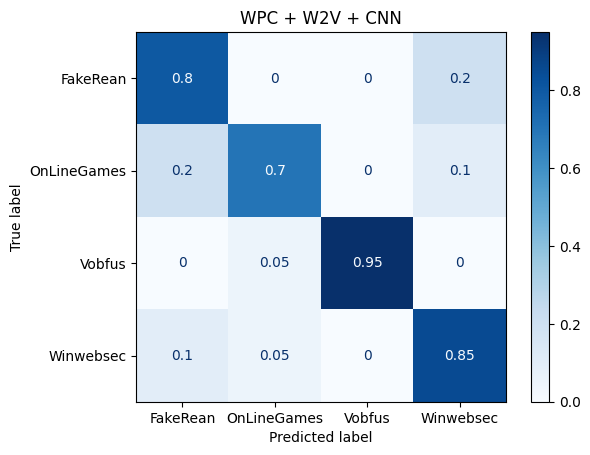

In [144]:
WPC_cnn_w2v, WPC_cnn_w2v_pred = fitCNN(WPC_train_w2v, WPC_test_w2v, WPC_y_train)
measures(WPC_cnn_w2v_pred, WPC_y_test, 'WPC + W2V + CNN')

#####SentencePiece

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_40 (Conv1D)          (None, 100, 500)          1000      
                                                                 
 dropout_40 (Dropout)        (None, 100, 500)          0         
                                                                 
 flatten_21 (Flatten)        (None, 50000)             0         
                                                                 
 dense_41 (Dense)            (None, 4)                 200004    
                                                                 
Total params: 201004 (785.17 KB)
Trainable params: 201004 (785.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
9/9 [==============================] - 3s 144ms/step - loss: 0.1481 - accuracy: 0.5174 - val_loss: 0.1340 - val_accuracy: 0.5938
Epoch 

3/3 [==============================] - 0s 13ms/step
F1: 84.97%
Precision: 85.19%
Recall: 85.0%
Accuracy: 85.0%
[[15  0  0  5]
 [ 2 17  0  1]
 [ 0  0 20  0]
 [ 1  2  1 16]]


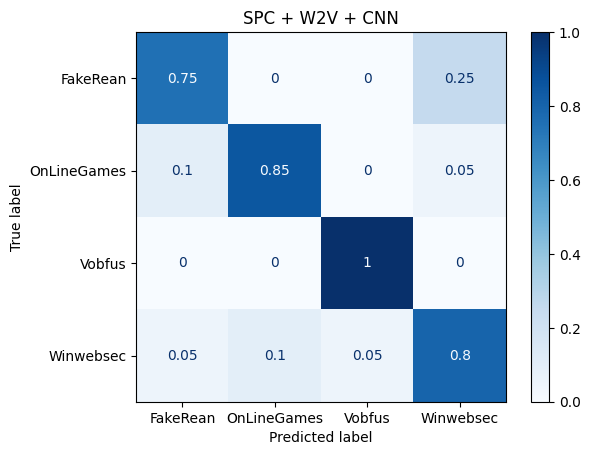

In [145]:
SPC_cnn_w2v, SPC_cnn_w2v_pred = fitCNN(SPC_train_w2v, SPC_test_w2v, SPC_y_train)
measures(SPC_cnn_w2v_pred, SPC_y_test, 'SPC + W2V + CNN')

#####Unigram Subword

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_41 (Conv1D)          (None, 100, 500)          1000      
                                                                 
 dropout_41 (Dropout)        (None, 100, 500)          0         
                                                                 
 flatten_22 (Flatten)        (None, 50000)             0         
                                                                 
 dense_42 (Dense)            (None, 4)                 200004    
                                                                 
Total params: 201004 (785.17 KB)
Trainable params: 201004 (785.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
9/9 [==============================] - 4s 122ms/step - loss: 0.1557 - accuracy: 0.5347 - val_loss: 0.1313 - val_accuracy: 0.5312
Epoch 

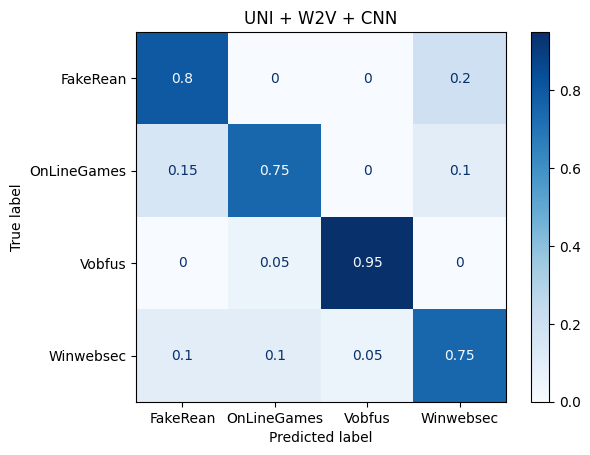

In [146]:
UNI_cnn_w2v, UNI_cnn_w2v_pred = fitCNN(UNI_train_w2v, UNI_test_w2v, UNI_y_train)
measures(UNI_cnn_w2v_pred, UNI_y_test, 'UNI + W2V + CNN')

####HMM2Vec

#####Single Words M=31

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_42 (Conv1D)          (None, 62, 500)           1000      
                                                                 
 dropout_42 (Dropout)        (None, 62, 500)           0         
                                                                 
 flatten_23 (Flatten)        (None, 31000)             0         
                                                                 
 dense_43 (Dense)            (None, 4)                 124004    
                                                                 
Total params: 125004 (488.30 KB)
Trainable params: 125004 (488.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
9/9 [==============================] - 1s 45ms/step - loss: 0.1851 - accuracy: 0.4618 - val_loss: 0.1844 - val_accuracy: 0.4062
Epoch 2

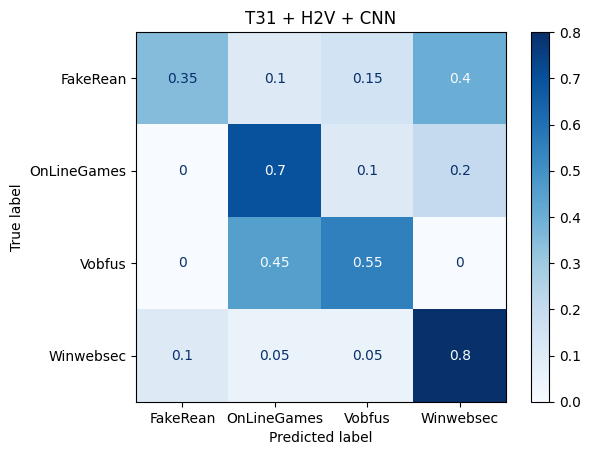

In [147]:
T31_cnn_h2v, T31_cnn_h2v_pred = fitCNN(T31_train_h2v, T31_test_h2v, T31_y_train)
measures(T31_cnn_h2v_pred, T31_y_test, 'T31 + H2V + CNN')

#####BPE

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_44 (Conv1D)          (None, 62, 500)           1000      
                                                                 
 dropout_44 (Dropout)        (None, 62, 500)           0         
                                                                 
 flatten_25 (Flatten)        (None, 31000)             0         
                                                                 
 dense_45 (Dense)            (None, 4)                 124004    
                                                                 
Total params: 125004 (488.30 KB)
Trainable params: 125004 (488.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
9/9 [==============================] - 2s 70ms/step - loss: 0.1870 - accuracy: 0.3611 - val_loss: 0.1866 - val_accuracy: 0.3750
Epoch 2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


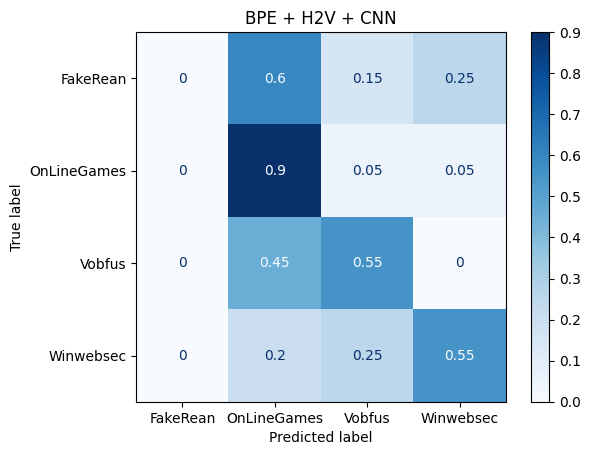

In [149]:
BPE_cnn_h2v, BPE_cnn_h2v_pred = fitCNN(BPE_train_h2v, BPE_test_h2v, BPE_y_train)
measures(BPE_cnn_h2v_pred, BPE_y_test, 'BPE + H2V + CNN')

#####WordPiece

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_46 (Conv1D)          (None, 62, 500)           1000      
                                                                 
 dropout_46 (Dropout)        (None, 62, 500)           0         
                                                                 
 flatten_27 (Flatten)        (None, 31000)             0         
                                                                 
 dense_47 (Dense)            (None, 4)                 124004    
                                                                 
Total params: 125004 (488.30 KB)
Trainable params: 125004 (488.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
9/9 [==============================] - 2s 62ms/step - loss: 0.1875 - accuracy: 0.2465 - val_loss: 0.1867 - val_accuracy: 0.4375
Epoch 2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


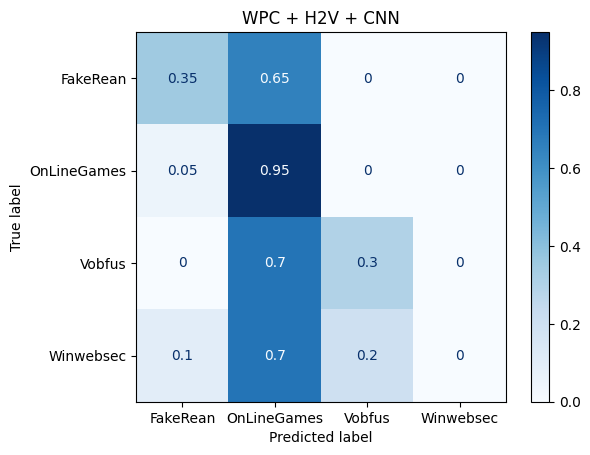

In [151]:
WPC_cnn_h2v, WPC_cnn_h2v_pred = fitCNN(WPC_train_h2v, WPC_test_h2v, WPC_y_train)
measures(WPC_cnn_h2v_pred, WPC_y_test, 'WPC + H2V + CNN')

#####SentencePiece

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_47 (Conv1D)          (None, 62, 500)           1000      
                                                                 
 dropout_47 (Dropout)        (None, 62, 500)           0         
                                                                 
 flatten_28 (Flatten)        (None, 31000)             0         
                                                                 
 dense_48 (Dense)            (None, 4)                 124004    
                                                                 
Total params: 125004 (488.30 KB)
Trainable params: 125004 (488.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
9/9 [==============================] - 3s 67ms/step - loss: 0.1874 - accuracy: 0.2465 - val_loss: 0.1873 - val_accuracy: 0.2812
Epoch 2

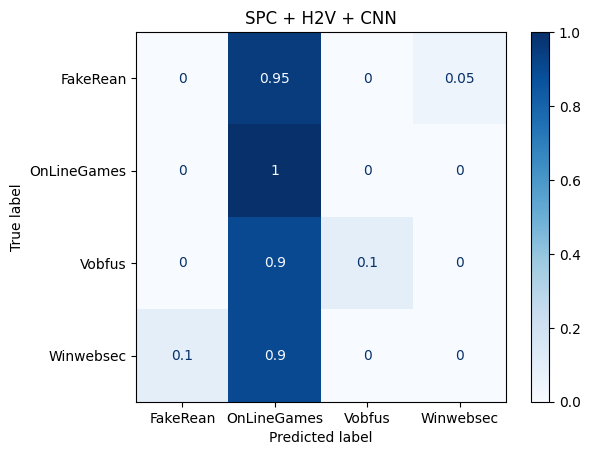

In [152]:
SPC_cnn_h2v, SPC_cnn_h2v_pred = fitCNN(SPC_train_h2v, SPC_test_h2v, SPC_y_train)
measures(SPC_cnn_h2v_pred, SPC_y_test, 'SPC + H2V + CNN')

#####Unigram Subword

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_48 (Conv1D)          (None, 62, 500)           1000      
                                                                 
 dropout_48 (Dropout)        (None, 62, 500)           0         
                                                                 
 flatten_29 (Flatten)        (None, 31000)             0         
                                                                 
 dense_49 (Dense)            (None, 4)                 124004    
                                                                 
Total params: 125004 (488.30 KB)
Trainable params: 125004 (488.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
9/9 [==============================] - 2s 73ms/step - loss: 0.1874 - accuracy: 0.2674 - val_loss: 0.1871 - val_accuracy: 0.1875
Epoch 2

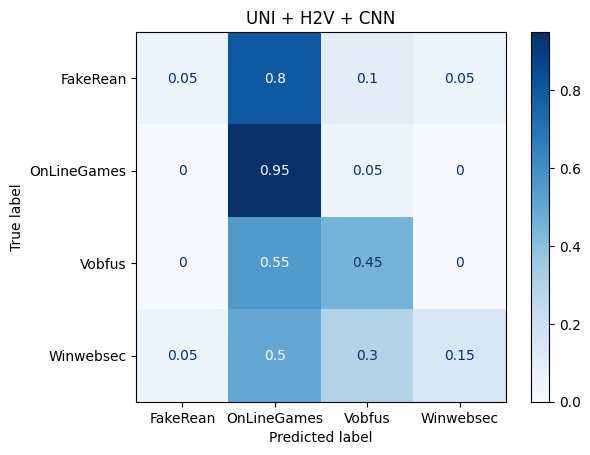

In [153]:
UNI_cnn_h2v, UNI_cnn_h2v_pred = fitCNN(UNI_train_h2v, UNI_test_h2v, UNI_y_train)
measures(UNI_cnn_h2v_pred, UNI_y_test, 'UNI + H2V + CNN')

####BERT

#####Single Words M=31

In [ ]:
T31_cnn_brt, T31_cnn_brt_pred = fitCNN(T31_train_brt, T31_test_brt, T31_y_train)
measures(T31_cnn_brt_pred, T31_y_test, 'T31 + BRT + CNN')

#####BPE

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_49 (Conv1D)          (None, 768, 500)          1000      
                                                                 
 dropout_49 (Dropout)        (None, 768, 500)          0         
                                                                 
 flatten_30 (Flatten)        (None, 384000)            0         
                                                                 
 dense_50 (Dense)            (None, 4)                 1536004   
                                                                 
Total params: 1537004 (5.86 MB)
Trainable params: 1537004 (5.86 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
9/9 [==============================] - 9s 530ms/step - loss: 0.2075 - accuracy: 0.3507 - val_loss: 0.1985 - val_accuracy: 0.3125
Epoch 2/

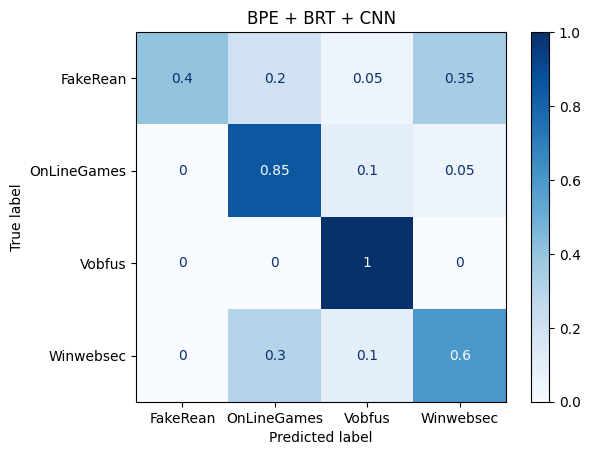

In [156]:
BPE_cnn_brt, BPE_cnn_brt_pred = fitCNN(BPE_train_brt, BPE_test_brt, BPE_y_train)
measures(BPE_cnn_brt_pred, BPE_y_test, 'BPE + BRT + CNN')